In [26]:
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
from scipy import integrate

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
lats = np.linspace(-90, 90, 361)
lons = np.linspace(-180, 179.375, 576)
levels = [1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300,
          250, 200, 150, 100, 70, 50, 40, 30, 20, 10, 7, 5, 4, 3, 2, 1, .7, .5, .4, .3, .1]

geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### WGET command to download

wget --content-disposition --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --content-disposition -i merra_links_list.txt 

In [6]:
merra_data = xr.open_mfdataset('raw_data/MERRA2_*')

merra_data

<xarray.Dataset>
Dimensions:   (time: 512, lat: 361, lon: 576, lev: 42)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lev       (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.5 0.4 0.3 0.1
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2022-08-01
Data variables:
    PS        (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    Cov_V_T   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    V         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    T         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    Cov_V_H   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    QV        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    Cov_V_QV  (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    H         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    History:                           Original file generated: Thu May  7 22...
    Filename:                          MERRA2_100.instM_3d_asm_Np.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.inst3_3d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/2E096JV59PK7
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   21:00:00.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2022-09-29 15:28:15 GMT Hyrax-1.16.3 h...

In [7]:
levels_array = np.array(levels[::-1])
mlev = 0
mlev = (levels_array[:-1] + levels_array[1:]) / 2
new_mlev = np.append(np.insert(mlev, 0, 0), 1000)

WEIGHT = np.empty((len(levels), len(lats), len(lons)))
ps = merra_data.PS.mean('time').values / 100 #To get in hPa

for i in range(len(lats)):
    for j in range(len(lons)):
        
        WEIGHT[:,i,j] = np.maximum(np.minimum(new_mlev[1:], ps[i,j] * np.ones(len(levels))) - new_mlev[:-1], np.zeros(len(levels))) * 100 / g
        
weight = (new_mlev[:-1] - new_mlev[1:]) * 100 / g

#(mlev(1:end-1) - mlev(2:end))*100/g

In [8]:
tmask = np.ones((len(levels), len(lats), len(lons)))
TMASK = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        lon_idxs = np.where(ps[j,:] < new_mlev[i])

        tmask[i,j,lon_idxs] = 0
        TMASK[i,j,lon_idxs] = np.nan

In [9]:
ZON_NORM = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        ZON_NORM[i,j,:] = WEIGHT[i,j,:] / np.maximum(np.sum(WEIGHT[i,j,:]), 1e-5)

In [10]:
ZON_WEIGHT = np.ones((len(levels), len(lats)))

for i in range(len(levels)):
    ZON_WEIGHT[i,:] = np.mean(WEIGHT[i,:,:], axis=1)

In [146]:
def aht_aaron_way(time_idx):
    v = merra_data.V.isel(time=time_idx).values[::-1, :, :]
    t = merra_data.T.isel(time=time_idx).values[::-1, :, :]
    q = merra_data.QV.isel(time=time_idx).values[::-1, :, :]
    z = merra_data.H.isel(time=time_idx).values[::-1, :, :]
    
    vt = merra_data.Cov_V_T.isel(time=time_idx).values[::-1, :, :]
    vq = merra_data.Cov_V_QV.isel(time=time_idx).values[::-1, :, :]
    vz = merra_data.Cov_V_H.isel(time=time_idx).values[::-1, :, :]


    WEIGHT[np.isnan(v)] = 0
    WEIGHT[np.isnan(t)] = 0
    WEIGHT[np.isnan(q)] = 0
    WEIGHT[np.isnan(z)] = 0

    v[np.isnan(v)] = 0
    t[np.isnan(t)] = 0
    q[np.isnan(q)] = 0
    z[np.isnan(z)] = 0
    vt[np.isnan(vt)] = 0
    vq[np.isnan(vq)] = 0
    vz[np.isnan(vz)] = 0

    SE = cp * t
    PE = g* z
    ME = L * q
    MSE = SE + PE + ME
    
    #SLIGHTLY DEVIATING HERE
    SE_bar = np.sum(ZON_NORM * SE, axis=2)
    ME_bar = np.sum(ZON_NORM * ME, axis=2)
    PE_bar = np.sum(ZON_NORM * PE, axis=2)
    V_bar = np.sum(ZON_NORM * v, axis=2)
    E_bar = np.sum(ZON_NORM * MSE, axis=2)

    Ve = v - V_bar[:,:,None]
    SEe = SE - SE_bar[:,:,None]
    MEe = ME - ME_bar[:,:,None]
    PEe = PE - PE_bar[:,:,None]
    
    VSEe_map = (Ve * SEe) * (WEIGHT / weight[:,None,None])
    VMEe_map = (Ve * MEe) * (WEIGHT / weight[:,None,None])
    VPEe_map = (Ve * PEe) * (WEIGHT / weight[:,None,None])
    
    #VSEe_map = np.ones((len(levels), len(lats), len(lons)))
    #VMEe_map = np.ones((len(levels), len(lats), len(lons)))
    #VPEe_map = np.ones((len(levels), len(lats), len(lons)))

    #for i in range(len(levels)):
        #for j in range(len(lats)):
            #VSEe_map[i,j,:] = (Ve[i,j,:] * SEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            #VMEe_map[i,j,:] = (Ve[i,j,:] * MEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            #VPEe_map[i,j,:] = (Ve[i,j,:] * PEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            
    VSEe_bar = np.mean(VSEe_map, axis=2)
    VMEe_bar = np.mean(VMEe_map, axis=2)
    VPEe_bar = np.mean(VPEe_map, axis=2)
    
    #VSEte_bar = np.ones((len(levels), len(lats)))
    #VMEte_bar = np.ones((len(levels), len(lats)))
    #VPEte_bar = np.ones((len(levels), len(lats)))

    #for i in range(len(levels)):
        #for j in range(len(lats)):
            #VSEte_bar[i,j] = np.mean(((vt[i,j,:] - (v[i,j,:] * t[i,j,:])) * cp) * (WEIGHT[i,j,:]/weight[i]))
            #VMEte_bar[i,j] = np.mean(((vq[i,j,:] - (v[i,j,:] * t[i,j,:])) * L) * (WEIGHT[i,j,:]/weight[i]))
            #VPEte_bar[i,j] = np.mean(((vz[i,j,:] - (v[i,j,:] * t[i,j,:])) * g) * (WEIGHT[i,j,:]/weight[i]))
            
            #VSEte_bar[i,j] = np.mean(((vt[i,j,:]) * cp) * (WEIGHT[i,j,:]/weight[i]))
            #VMEte_bar[i,j] = np.mean(((vq[i,j,:]) * L) * (WEIGHT[i,j,:]/weight[i]))
            #VPEte_bar[i,j] = np.mean(((vz[i,j,:]) * g) * (WEIGHT[i,j,:]/weight[i]))
            
    VSEte_map = (vt * cp) * (WEIGHT / weight[:,None,None])
    VMEte_map = (vq * L) * (WEIGHT / weight[:,None,None])
    VPEte_map = (vz * g) * (WEIGHT / weight[:,None,None])

    VSEte_bar = np.mean(VSEte_map, axis=2)
    VMEte_bar = np.mean(VMEte_map, axis=2)
    VPEte_bar = np.mean(VPEte_map, axis=2)
        
    
    #V_barotropic = np.zeros(len(lats))

    #V_bar_new = np.zeros((len(levels), len(lats)))
    #for i in range(len(lats)):
        #V_barotropic[i] = np.sum(V_bar[:,i] * (ZON_WEIGHT[:,i] / np.sum(ZON_WEIGHT[:,i])))

        #V_bar_new[:,i] = V_bar[:,i] - V_barotropic[i]
        
    V_barotropic = np.sum(V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    
    V_bar_new = V_bar - V_barotropic[None,:]


    MME = np.sum(ZON_WEIGHT * V_bar_new * E_bar, axis=0)
    MASS = np.sum(ZON_WEIGHT * V_bar_new, axis=0)
    MME_moist = np.sum(ZON_WEIGHT * V_bar_new * ME_bar, axis=0)
    MME_dry = np.sum(ZON_WEIGHT * V_bar_new * SE_bar, axis=0)
    MME_pot = np.sum(ZON_WEIGHT * V_bar_new * PE_bar, axis=0)
    
    SE_dry = np.sum(weight[:,None] * VSEe_bar, axis=0)
    SE_pot = np.sum(weight[:,None] * VPEe_bar, axis=0)
    SE_moist = np.sum(weight[:,None] * VMEe_bar, axis=0)
    
    SE = SE_dry + SE_pot + SE_moist
    
    TE_dry = np.sum(weight[:,None] * VSEte_bar, axis=0)
    TE_pot = np.sum(weight[:,None] * VPEte_bar, axis=0)
    TE_moist = np.sum(weight[:,None] * VMEte_bar, axis=0)
    
    TE = TE_dry + TE_pot + TE_moist
    
    return MME, MME_moist, MME_dry, MME_pot, SE, SE_moist, SE_dry, SE_pot, TE, TE_moist, TE_dry, TE_pot



In [45]:
num_months = len(merra_data.time)

TEs = np.zeros((num_months, len(lats)))
TEs_moist = np.zeros((num_months, len(lats)))
TEs_dry = np.zeros((num_months, len(lats)))
TEs_pot = np.zeros((num_months, len(lats)))
SEs = np.zeros((num_months, len(lats)))
SEs_moist = np.zeros((num_months, len(lats)))
SEs_dry = np.zeros((num_months, len(lats)))
SEs_pot = np.zeros((num_months, len(lats)))
MMEs = np.zeros((num_months, len(lats)))
MMEs_moist = np.zeros((num_months, len(lats)))
MMEs_dry = np.zeros((num_months, len(lats)))
MMEs_pot = np.zeros((num_months, len(lats)))

for i in range(num_months):
    values = aht_aaron_way(i)
    MMEs[i,:] = values[0]
    MMEs_moist[i,:] = values[1]
    MMEs_dry[i,:] = values[2]
    MMEs_pot[i,:] = values[3]
    
    SEs[i,:] = values[4]
    SEs_moist[i,:] = values[5]
    SEs_dry[i,:] = values[6]
    SEs_pot[i,:] = values[7]
    
    TEs[i,:] = values[8]
    TEs_moist[i,:] = values[9]
    TEs_dry[i,:] = values[10]
    TEs_pot[i,:] = values[11]

In [46]:
TOT = MMEs + SEs + TEs
TOT_moist = MMEs_moist + SEs_moist + TEs_moist
TOT_dry = MMEs_dry + SEs_dry + TEs_dry
TOT_pot = MMEs_pot + SEs_pot + TEs_pot

In [52]:
final_ds = xr.Dataset(
                    data_vars = dict(
                        total_aht=(['time','latitude'], TOT * (geometry * g)[None,:]),
                        total_aht_dry=(['time','latitude'], TOT_dry * (geometry * g)[None,:]),
                        total_aht_moist=(['time','latitude'], TOT_moist * (geometry * g)[None,:]),
                        total_aht_pot=(['time','latitude'], TOT_pot * (geometry * g)[None,:]),
                        mmc_aht=(['time','latitude'], MMEs * (geometry * g)[None,:]),
                        mmc_aht_dry=(['time','latitude'], MMEs_dry * (geometry * g)[None,:]),
                        mmc_aht_moist=(['time','latitude'], MMEs_moist * (geometry * g)[None,:]),
                        mmc_aht_pot=(['time','latitude'], MMEs_pot * (geometry * g)[None,:]),
                        se_aht=(['time','latitude'], SEs * (geometry * g)[None,:]),
                        se_aht_dry=(['time','latitude'], SEs_dry * (geometry * g)[None,:]),
                        se_aht_moist=(['time','latitude'], SEs_moist * (geometry * g)[None,:]),
                        se_aht_pot=(['time','latitude'], SEs_pot * (geometry * g)[None,:]),
                        te_aht=(['time','latitude'], TEs * (geometry * g)[None,:]),
                        te_aht_dry=(['time','latitude'], TEs_dry * (geometry * g)[None,:]),
                        te_aht_moist=(['time','latitude'], TEs_moist * (geometry * g)[None,:]),
                        te_aht_pot=(['time','latitude'], TEs_pot * (geometry * g)[None,:]),
                    ),
                    coords=dict(
                        time=merra_data.time,
                        latitude=lats,)
)

#final_ds.to_netcdf('merra_aht_no_mass_correction.nc')

In [37]:
#final_ds.total_aht.sel(time=slice('2000-01-01', '2018-12-31')).mean('time').to_netcdf('merra2_total_aht_2000_2018.nc')

In [48]:
orig_ds = xr.open_dataset('merra_aht.nc')


orig_ds['total_aht_dry_pot'] = orig_ds.total_aht_dry + orig_ds.total_aht_pot
orig_ds['te_aht_dry_pot'] = orig_ds.te_aht_dry + orig_ds.te_aht_pot
orig_ds['se_aht_dry_pot'] = orig_ds.se_aht_dry + orig_ds.se_aht_pot
orig_ds['mmc_aht_dry_pot'] = orig_ds.mmc_aht_dry + orig_ds.mmc_aht_pot

orig_ds['eddy_aht'] = orig_ds.te_aht + orig_ds.se_aht
orig_ds['eddy_aht_dry'] = orig_ds.te_aht_dry + orig_ds.se_aht_dry
orig_ds['eddy_aht_moist'] = orig_ds.te_aht_moist + orig_ds.se_aht_moist
orig_ds['eddy_aht_pot'] = orig_ds.te_aht_pot + orig_ds.se_aht_pot
orig_ds['eddy_aht_dry_pot'] = orig_ds.te_aht_dry_pot + orig_ds.se_aht_dry_pot

final_ds['total_aht_dry_pot'] = final_ds.total_aht_dry + final_ds.total_aht_pot
final_ds['te_aht_dry_pot'] = final_ds.te_aht_dry + final_ds.te_aht_pot
final_ds['se_aht_dry_pot'] = final_ds.se_aht_dry + final_ds.se_aht_pot
final_ds['mmc_aht_dry_pot'] = final_ds.mmc_aht_dry + final_ds.mmc_aht_pot

final_ds['eddy_aht'] = final_ds.te_aht + final_ds.se_aht
final_ds['eddy_aht_dry'] = final_ds.te_aht_dry + final_ds.se_aht_dry
final_ds['eddy_aht_moist'] = final_ds.te_aht_moist + final_ds.se_aht_moist
final_ds['eddy_aht_pot'] = final_ds.te_aht_pot + final_ds.se_aht_pot
final_ds['eddy_aht_dry_pot'] = final_ds.te_aht_dry_pot + final_ds.se_aht_dry_pot

In [49]:
orig_trends = orig_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
new_trends = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

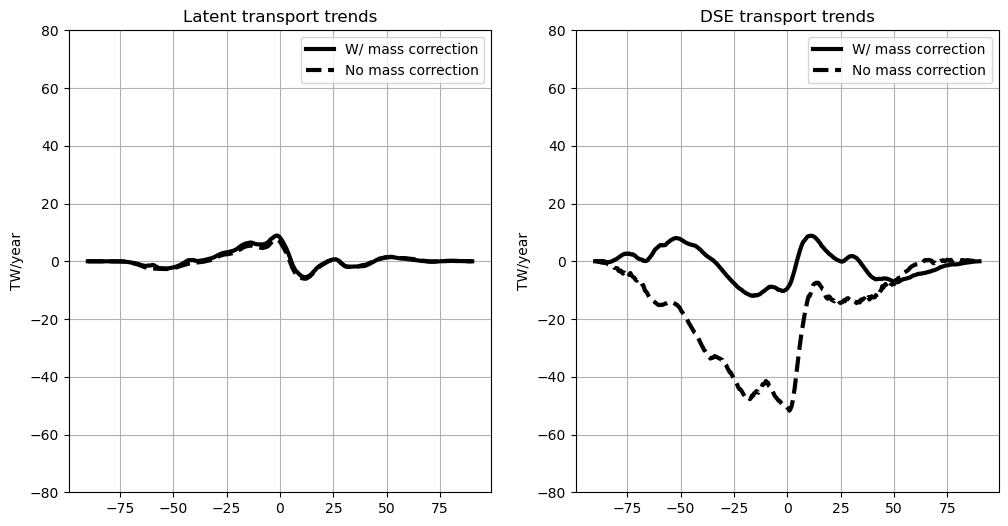

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(lats, (orig_trends.total_aht_moist_polyfit_coefficients.sel(degree=1)/1e12), color='k', lw=3, label='W/ mass correction')
axs[0].plot(lats, (new_trends.total_aht_moist_polyfit_coefficients.sel(degree=1)/1e12), '--', lw=3, color='k',
            label='No mass correction')
axs[0].set_title('Latent transport trends')
axs[0].legend(loc=0)
axs[0].grid()
axs[0].set_ylabel('TW/year')
axs[0].set_ylim([-80, 80])

axs[1].plot(lats, (orig_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1)/1e12), color='k', lw=3, label='W/ mass correction')
axs[1].plot(lats, (new_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1)/1e12), '--', lw=3, color='k',
            label='No mass correction')
axs[1].set_title('DSE transport trends')
axs[1].legend(loc=0)
axs[1].grid()
axs[1].set_ylabel('TW/year')
axs[1].set_ylim([-80, 80])

plt.show()

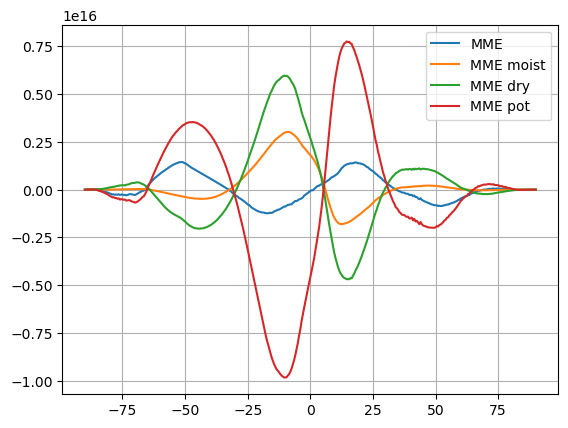

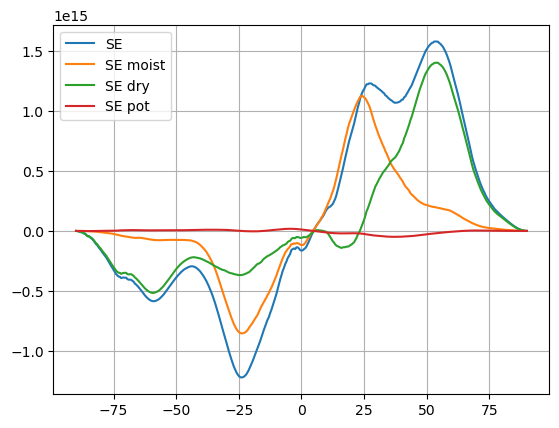

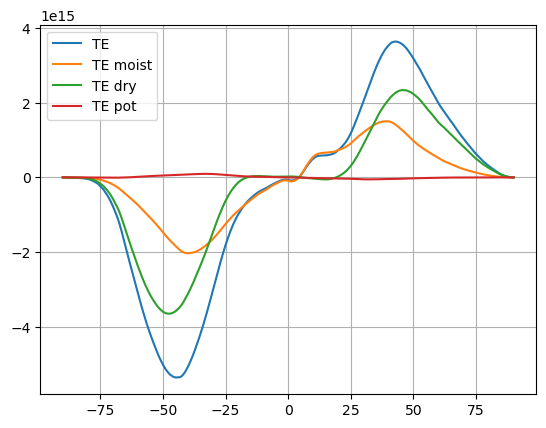

In [15]:
plt.plot(lats, np.mean(MMEs, axis=0) * geometry * g, label='MME')
plt.plot(lats, np.mean(MMEs_moist, axis=0) * geometry * g, label='MME moist')
plt.plot(lats, np.mean(MMEs_dry, axis=0) * geometry * g, label='MME dry')
plt.plot(lats, np.mean(MMEs_pot, axis=0) * geometry * g, label='MME pot')

plt.legend(loc=0)
plt.grid()
plt.show()

plt.plot(lats, np.mean(SEs, axis=0) * geometry * g, label='SE')
plt.plot(lats, np.mean(SEs_moist, axis=0) * geometry * g, label='SE moist')
plt.plot(lats, np.mean(SEs_dry, axis=0) * geometry * g, label='SE dry')
plt.plot(lats, np.mean(SEs_pot, axis=0) * geometry * g, label='SE pot')

plt.legend(loc=0)
plt.grid()
plt.show()

plt.plot(lats, np.mean(TEs, axis=0) * geometry * g, label='TE')
plt.plot(lats, np.mean(TEs_moist, axis=0) * geometry * g, label='TE moist')
plt.plot(lats, np.mean(TEs_dry, axis=0) * geometry * g, label='TE dry')
plt.plot(lats, np.mean(TEs_pot, axis=0) * geometry * g, label='TE pot')

plt.legend(loc=0)
plt.grid()
plt.show()

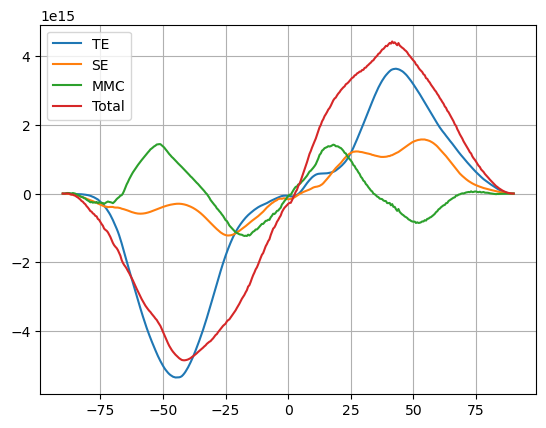

In [17]:
plt.plot(lats, np.mean(TEs, axis=0) * geometry * g, label='TE')
plt.plot(lats, np.mean(SEs, axis=0) * geometry * g, label='SE')
plt.plot(lats, np.mean(MMEs, axis=0) * geometry * g, label='MMC')
plt.plot(lats, np.mean(TEs + SEs + MMEs, axis=0) * geometry * g, label='Total')

plt.legend(loc=0)
plt.grid()
plt.show()

In [129]:
def aht_aaron_way2(time_idx):
    v = merra_data.V.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    t = merra_data.T.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    q = merra_data.QV.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    z = merra_data.H.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    
    vt = merra_data.Cov_V_T.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    vq = merra_data.Cov_V_QV.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    vz = merra_data.Cov_V_H.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]


    WEIGHT[np.isnan(v)] = 0
    WEIGHT[np.isnan(t)] = 0
    WEIGHT[np.isnan(q)] = 0
    WEIGHT[np.isnan(z)] = 0

    #v[np.isnan(v)] = 0
    #t[np.isnan(t)] = 0
    #q[np.isnan(q)] = 0
    #z[np.isnan(z)] = 0
    #vt[np.isnan(vt)] = 0
    #vq[np.isnan(vq)] = 0
    #vz[np.isnan(vz)] = 0
    
    v = v.fillna(0)
    t = t.fillna(0)
    q = q.fillna(0)
    z = z.fillna(0)
    vt = vt.fillna(0)
    vq = vq.fillna(0)
    vz = vz.fillna(0)
    
    SE = cp * t
    PE = g* z
    ME = L * q
    MSE = SE + PE + ME
    
    #SLIGHTLY DEVIATING HERE
    SE_bar = (ZON_NORM * SE).sum(axis=2)
    ME_bar = (ZON_NORM * ME).sum(axis=2)
    PE_bar = (ZON_NORM * PE).sum(axis=2)
    V_bar = (ZON_NORM * v).sum(axis=2)
    E_bar = (ZON_NORM * MSE).sum(axis=2)

    Ve = v - V_bar#[:,:,None]
    SEe = SE - SE_bar#[:,:,None]
    MEe = ME - ME_bar#[:,:,None]
    PEe = PE - PE_bar#[:,:,None]
    
    #VSEe_map = np.ones((len(levels), len(lats), len(lons)))
    #VMEe_map = np.ones((len(levels), len(lats), len(lons)))
    #VPEe_map = np.ones((len(levels), len(lats), len(lons)))

    VSEe_map = (Ve * SEe) * (WEIGHT / weight[:,None,None])
    VMEe_map = (Ve * MEe) * (WEIGHT / weight[:,None,None])
    VPEe_map = (Ve * PEe) * (WEIGHT / weight[:,None,None])
    
    #for i in range(len(levels)):
        #for j in range(len(lats)):
            #VSEe_map[i,j,:] = (Ve[i,j,:] * SEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            #VMEe_map[i,j,:] = (Ve[i,j,:] * MEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            #VPEe_map[i,j,:] = (Ve[i,j,:] * PEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            
    VSEe_bar = VSEe_map.mean(axis=2)
    VMEe_bar = VMEe_map.mean(axis=2)
    VPEe_bar = VPEe_map.mean(axis=2)
    
    #VSEte_bar = np.ones((len(levels), len(lats)))
    #VMEte_bar = np.ones((len(levels), len(lats)))
    #VPEte_bar = np.ones((len(levels), len(lats)))
    
    VSEte_map = (vt * cp) * (WEIGHT / weight[:,None,None])
    VMEte_map = (vq * L) * (WEIGHT / weight[:,None,None])
    VPEte_map = (vz * g) * (WEIGHT / weight[:,None,None])

    VSEte_bar = VSEte_map.mean(axis=2)
    VMEte_bar = VMEte_map.mean(axis=2)
    VPEte_bar = VPEte_map.mean(axis=2)
    
    #for i in range(len(levels)):
        #for j in range(len(lats)):
            
            #VSEte_bar[i,j] = np.mean(((vt[i,j,:]) * cp) * (WEIGHT[i,j,:]/weight[i]))
            #VMEte_bar[i,j] = np.mean(((vq[i,j,:]) * L) * (WEIGHT[i,j,:]/weight[i]))
            #VPEte_bar[i,j] = np.mean(((vz[i,j,:]) * g) * (WEIGHT[i,j,:]/weight[i]))
        
    
    #V_barotropic = np.zeros(len(lats))

    #V_bar_new = np.zeros((len(levels), len(lats)))
    
    V_barotropic = (V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:])).sum(axis=0)
    
    V_bar_new = V_bar - V_barotropic
    
    #for i in range(len(lats)):
        #V_barotropic[i] = np.sum(V_bar[:,i] * (ZON_WEIGHT[:,i] / np.sum(ZON_WEIGHT[:,i])))

        #V_bar_new[:,i] = V_bar[:,i] - V_barotropic[i]


    MME = (ZON_WEIGHT * V_bar_new * E_bar).sum(axis=0)
    MASS = (ZON_WEIGHT * V_bar_new).sum(axis=0)
    MME_moist = (ZON_WEIGHT * V_bar_new * ME_bar).sum(axis=0)
    MME_dry = (ZON_WEIGHT * V_bar_new * SE_bar).sum(axis=0)
    MME_pot = (ZON_WEIGHT * V_bar_new * PE_bar).sum(axis=0)
    
    SE_dry = (weight[:,None] * VSEe_bar).sum(axis=0)
    SE_pot = (weight[:,None] * VPEe_bar).sum(axis=0)
    SE_moist = (weight[:,None] * VMEe_bar).sum(axis=0)
    
    SE = SE_dry + SE_pot + SE_moist
    
    TE_dry = (weight[:,None] * VSEte_bar).sum(axis=0)
    TE_pot = (weight[:,None] * VPEte_bar).sum(axis=0)
    TE_moist = (weight[:,None] * VMEte_bar).sum(axis=0)
    
    TE = TE_dry + TE_pot + TE_moist
    
    return MME, MME_moist, MME_dry, MME_pot, SE, SE_moist, SE_dry, SE_pot, TE, TE_moist, TE_dry, TE_pot



In [143]:
def aht_aaron_way3(time_idx):
    v = merra_data.V.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    t = merra_data.T.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    q = merra_data.QV.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    z = merra_data.H.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    
    vt = merra_data.Cov_V_T.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    vq = merra_data.Cov_V_QV.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]
    vz = merra_data.Cov_V_H.isel(time=time_idx).isel(lev=slice(None, None, -1))#[::-1, :, :]


    WEIGHT[np.isnan(v)] = 0
    WEIGHT[np.isnan(t)] = 0
    WEIGHT[np.isnan(q)] = 0
    WEIGHT[np.isnan(z)] = 0

    #v[np.isnan(v)] = 0
    #t[np.isnan(t)] = 0
    #q[np.isnan(q)] = 0
    #z[np.isnan(z)] = 0
    #vt[np.isnan(vt)] = 0
    #vq[np.isnan(vq)] = 0
    #vz[np.isnan(vz)] = 0
    
    v = v.fillna(0)
    t = t.fillna(0)
    q = q.fillna(0)
    z = z.fillna(0)
    vt = vt.fillna(0)
    vq = vq.fillna(0)
    vz = vz.fillna(0)
    
    SE = cp * t
    PE = g* z
    ME = L * q
    MSE = SE + PE + ME
    
    #SLIGHTLY DEVIATING HERE
    SE_bar = (ZON_NORM * SE).sum(axis=2)
    ME_bar = (ZON_NORM * ME).sum(axis=2)
    PE_bar = (ZON_NORM * PE).sum(axis=2)
    V_bar = (ZON_NORM * v).sum(axis=2)
    E_bar = (ZON_NORM * MSE).sum(axis=2)

    Ve = v - V_bar#[:,:,None]
    SEe = SE - SE_bar#[:,:,None]
    MEe = ME - ME_bar#[:,:,None]
    PEe = PE - PE_bar#[:,:,None]
    
    #VSEe_map = np.ones((len(levels), len(lats), len(lons)))
    #VMEe_map = np.ones((len(levels), len(lats), len(lons)))
    #VPEe_map = np.ones((len(levels), len(lats), len(lons)))

    VSEe_map = (Ve * SEe) * (WEIGHT / weight[:,None,None])
    VMEe_map = (Ve * MEe) * (WEIGHT / weight[:,None,None])
    VPEe_map = (Ve * PEe) * (WEIGHT / weight[:,None,None])
    
    #for i in range(len(levels)):
        #for j in range(len(lats)):
            #VSEe_map[i,j,:] = (Ve[i,j,:] * SEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            #VMEe_map[i,j,:] = (Ve[i,j,:] * MEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            #VPEe_map[i,j,:] = (Ve[i,j,:] * PEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
            
    VSEe_bar = VSEe_map.mean(axis=2)
    VMEe_bar = VMEe_map.mean(axis=2)
    VPEe_bar = VPEe_map.mean(axis=2)
    
    #VSEte_bar = np.ones((len(levels), len(lats)))
    #VMEte_bar = np.ones((len(levels), len(lats)))
    #VPEte_bar = np.ones((len(levels), len(lats)))
    
    VSEte_map = (vt * cp) * (WEIGHT / weight[:,None,None])
    VMEte_map = (vq * L) * (WEIGHT / weight[:,None,None])
    VPEte_map = (vz * g) * (WEIGHT / weight[:,None,None])

    VSEte_bar = VSEte_map.mean(axis=2)
    VMEte_bar = VMEte_map.mean(axis=2)
    VPEte_bar = VPEte_map.mean(axis=2)
    
    #for i in range(len(levels)):
        #for j in range(len(lats)):
            
            #VSEte_bar[i,j] = np.mean(((vt[i,j,:]) * cp) * (WEIGHT[i,j,:]/weight[i]))
            #VMEte_bar[i,j] = np.mean(((vq[i,j,:]) * L) * (WEIGHT[i,j,:]/weight[i]))
            #VPEte_bar[i,j] = np.mean(((vz[i,j,:]) * g) * (WEIGHT[i,j,:]/weight[i]))
        
    
    #V_barotropic = np.zeros(len(lats))

    #V_bar_new = np.zeros((len(levels), len(lats)))
    
    V_barotropic = (V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:])).sum(axis=0)
    
    V_bar_new = V_bar - V_barotropic
    
    #for i in range(len(lats)):
        #V_barotropic[i] = np.sum(V_bar[:,i] * (ZON_WEIGHT[:,i] / np.sum(ZON_WEIGHT[:,i])))

        #V_bar_new[:,i] = V_bar[:,i] - V_barotropic[i]


    MME = (ZON_WEIGHT * V_bar_new * E_bar).sum(axis=0)
    MASS = (ZON_WEIGHT * V_bar_new).sum(axis=0)
    MME_moist = (ZON_WEIGHT * V_bar_new * ME_bar).sum(axis=0)
    MME_dry = (ZON_WEIGHT * V_bar_new * SE_bar).sum(axis=0)
    MME_pot = (ZON_WEIGHT * V_bar_new * PE_bar).sum(axis=0)
    
    SE_dry = (weight[:,None] * VSEe_bar).sum(axis=0)
    SE_pot = (weight[:,None] * VPEe_bar).sum(axis=0)
    SE_moist = (weight[:,None] * VMEe_bar).sum(axis=0)
    
    SE = SE_dry + SE_pot + SE_moist
    
    TE_dry = (weight[:,None] * VSEte_bar).sum(axis=0)
    TE_pot = (weight[:,None] * VPEte_bar).sum(axis=0)
    TE_moist = (weight[:,None] * VMEte_bar).sum(axis=0)
    
    TE = TE_dry + TE_pot + TE_moist
    
    this_time_ds = xr.Dataset(
                    data_vars = dict(
                        mmc_aht=(['latitude'], MME.data),
                        mmc_aht_dry=(['latitude'], MME_dry.data),
                        mmc_aht_moist=(['latitude'], MME_moist.data),
                        mmc_aht_pot=(['latitude'], MME_pot.data),
                        se_aht=(['latitude'], SE.data),
                        se_aht_dry=(['latitude'], SE_dry.data),
                        se_aht_moist=(['latitude'], SE_moist.data),
                        se_aht_pot=(['latitude'], SE_pot.data),
                        te_aht=(['latitude'], TE.data),
                        te_aht_dry=(['latitude'], TE_dry.data),
                        te_aht_moist=(['latitude'], TE_moist.data),
                        te_aht_pot=(['latitude'], TE_pot.data),
                    ),
                    coords=dict(
                        time=v.time,
                        latitude=v.lat,)
)
    
    return this_time_ds



In [144]:
test = aht_aaron_way3(0)

MergeError: coordinate latitude shares a name with a dataset dimension, but is not a 1D variable along that dimension. This is disallowed by the xarray data model.

In [147]:
num_months = 3

TEs1 = np.zeros((num_months, len(lats)))
TEs_moist1 = np.zeros((num_months, len(lats)))
TEs_dry1 = np.zeros((num_months, len(lats)))
TEs_pot1 = np.zeros((num_months, len(lats)))
SEs1 = np.zeros((num_months, len(lats)))
SEs_moist1 = np.zeros((num_months, len(lats)))
SEs_dry1 = np.zeros((num_months, len(lats)))
SEs_pot1 = np.zeros((num_months, len(lats)))
MMEs1 = np.zeros((num_months, len(lats)))
MMEs_moist1 = np.zeros((num_months, len(lats)))
MMEs_dry1 = np.zeros((num_months, len(lats)))
MMEs_pot1 = np.zeros((num_months, len(lats)))

for i in range(num_months):
    start_time = time.time()
    values = aht_aaron_way(i)
    
    MMEs1[i,:] = values[0]
    MMEs_moist1[i,:] = values[1]
    MMEs_dry1[i,:] = values[2]
    MMEs_pot1[i,:] = values[3]
    
    SEs1[i,:] = values[4]
    SEs_moist1[i,:] = values[5]
    SEs_dry1[i,:] = values[6]
    SEs_pot1[i,:] = values[7]
    
    TEs1[i,:] = values[8]
    TEs_moist1[i,:] = values[9]
    TEs_dry1[i,:] = values[10]
    TEs_pot1[i,:] = values[11]
    print(time.time() - start_time)

2.462524652481079
2.5304853916168213
2.4029860496520996


In [148]:
num_months = 3

TEs2 = np.zeros((num_months, len(lats)))
TEs_moist2 = np.zeros((num_months, len(lats)))
TEs_dry2 = np.zeros((num_months, len(lats)))
TEs_pot2 = np.zeros((num_months, len(lats)))
SEs2 = np.zeros((num_months, len(lats)))
SEs_moist2 = np.zeros((num_months, len(lats)))
SEs_dry2 = np.zeros((num_months, len(lats)))
SEs_pot2 = np.zeros((num_months, len(lats)))
MMEs2 = np.zeros((num_months, len(lats)))
MMEs_moist2 = np.zeros((num_months, len(lats)))
MMEs_dry2 = np.zeros((num_months, len(lats)))
MMEs_pot2 = np.zeros((num_months, len(lats)))

for i in range(num_months):
    start_time = time.time()
    values = aht_aaron_way2(i)
    
    MMEs2[i,:] = values[0]
    MMEs_moist2[i,:] = values[1]
    MMEs_dry2[i,:] = values[2]
    MMEs_pot2[i,:] = values[3]
    
    SEs2[i,:] = values[4]
    SEs_moist2[i,:] = values[5]
    SEs_dry2[i,:] = values[6]
    SEs_pot2[i,:] = values[7]
    
    TEs2[i,:] = values[8]
    TEs_moist2[i,:] = values[9]
    TEs_dry2[i,:] = values[10]
    TEs_pot2[i,:] = values[11]
    print(time.time() - start_time)

10.060137271881104
11.325742244720459
10.425710916519165


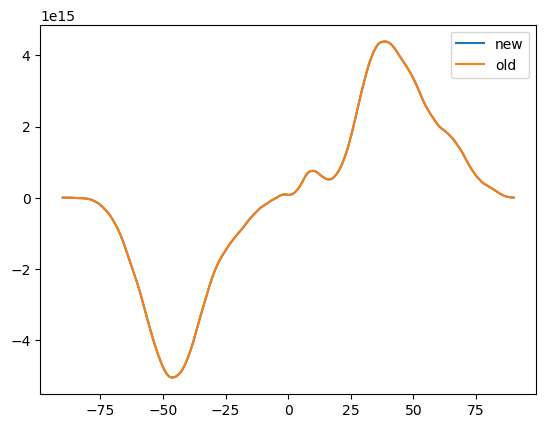

In [149]:
plt.plot(lats, np.mean(TEs2, axis=0) * geometry * g, label='new')
plt.plot(lats, np.mean(TEs1, axis=0) * geometry * g, label='old')

plt.legend(loc=0)
plt.show()

In [367]:
v = merra_data.V.isel(time=10).values
t = merra_data.T.isel(time=10).values
q = merra_data.QV.isel(time=10).values
z = merra_data.H.isel(time=10).values

WEIGHT[np.isnan(v)] = 0
WEIGHT[np.isnan(t)] = 0
WEIGHT[np.isnan(q)] = 0
WEIGHT[np.isnan(z)] = 0

v[np.isnan(v)] = 0
t[np.isnan(t)] = 0
q[np.isnan(q)] = 0
z[np.isnan(z)] = 0

SE = cp * t
PE = g* z
ME = L * q
MSE = SE + PE + ME

In [368]:
#SLIGHTLY DEVIATING HERE
SE_bar = np.sum(ZON_NORM * SE, axis=2)
ME_bar = np.sum(ZON_NORM * ME, axis=2)
PE_bar = np.sum(ZON_NORM * PE, axis=2)
V_bar = np.sum(ZON_NORM * v, axis=2)
E_bar = np.sum(ZON_NORM * MSE, axis=2)

Ve = v - V_bar[:,:,None]
SEe = SE - SE_bar[:,:,None]
MEe = ME - ME_bar[:,:,None]
PEe = PE - PE_bar[:,:,None]

In [369]:
VSEe_map = np.ones((len(levels), len(lats), len(lons)))
VMEe_map = np.ones((len(levels), len(lats), len(lons)))
VPEe_map = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        VSEe_map[i,j,:] = (Ve[i,j,:] * SEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
        VMEe_map[i,j,:] = (Ve[i,j,:] * MEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])
        VPEe_map[i,j,:] = (Ve[i,j,:] * PEe[i,j,:]) * (WEIGHT[i,j,:]/weight[i])   

In [370]:
VSEe_bar = np.mean(VSEe_map, axis=2)
VMEe_bar = np.mean(VMEe_map, axis=2)
VPEe_bar = np.mean(VPEe_map, axis=2)


In [371]:
V_barotropic = np.zeros(len(lats))

V_bar_new = np.zeros((len(levels), len(lats)))
for i in range(len(lats)):
    V_barotropic[i] = np.sum(V_bar[:,i] * (ZON_WEIGHT[:,i] / np.sum(ZON_WEIGHT[:,i])))
    
    V_bar_new[:,i] = V_bar[:,i] - V_barotropic[i]


MME = np.sum(ZON_WEIGHT * V_bar_new * E_bar, axis=0)
MASS = np.sum(ZON_WEIGHT * V_bar_new, axis=0)
MME_moist = np.sum(ZON_WEIGHT * V_bar_new * ME_bar, axis=0)
MME_dry = np.sum(ZON_WEIGHT * V_bar_new * SE_bar, axis=0)
MME_pot = np.sum(ZON_WEIGHT * V_bar_new * PE_bar, axis=0)


In [372]:
SE_dry = np.sum(weight[:,None] * VSEe_bar, axis=0)
SE_pot = np.sum(weight[:,None] * VPEe_bar, axis=0)
SE_moist = np.sum(weight[:,None] * VMEe_bar, axis=0)

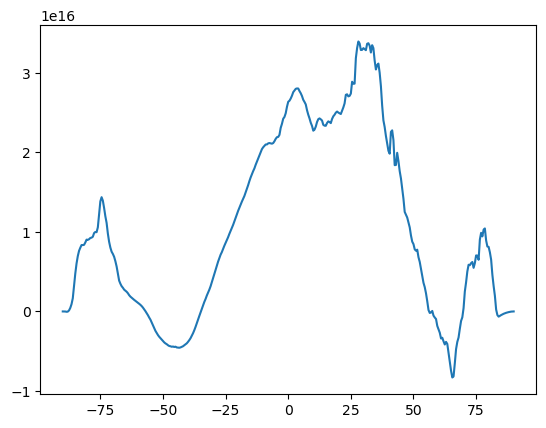

In [376]:
plt.plot(lats, MME_pot * geometry)

plt.show()

In [ ]:

for nl=1:NL;
    for nn=1:NN;  
        SE_bar(nl,nn)=squeeze(ZON_NORM(nl,nn,:))'*(squeeze(SE(nl,nn,:))); %zonal time mean energy - normalized by the amount of air above topography in each layer 
        ME_bar(nl,nn)=squeeze(ZON_NORM(nl,nn,:))'*(squeeze(ME(nl,nn,:))); %zonal time mean energy - normalized by the amount of air above topography in each layer 
        PE_bar(nl,nn)=squeeze(ZON_NORM(nl,nn,:))'*(squeeze(PE(nl,nn,:))); %zonal time mean energy - normalized by the amount of air above topography in each layer 
        
        V_bar(nl,nn)=squeeze(ZON_NORM(nl,nn,:))'*(squeeze((squeeze(v(nl,nn,:))))); %zonal time mean meridional velocity
        E_bar(nl,nn)=squeeze(ZON_NORM(nl,nn,:))'*(squeeze((squeeze(MSE(nl,nn,:))))); %zonal time mean energy - normalized by the amount of air above topography in each layer 

        
        %define the steady eddies
        for n=1:N
            Ve(nl, nn,n)=(squeeze(v(nl,nn,n))) - V_bar(nl,nn); %steady eddy meridional velocity- straight mean, topography is masked when the heat transport map is composed
            SEe(nl, nn,n)=(squeeze(SE(nl,nn,n))) - SE_bar(nl,nn); %steady eddy energy - ditto
            MEe(nl, nn,n)=(squeeze(ME(nl,nn,n))) - ME_bar(nl,nn); %steady eddy energy - ditto
            PEe(nl, nn,n)=(squeeze(PE(nl,nn,n))) - PE_bar(nl,nn); %steady eddy energy - ditto

        end
        

                
        %construct the steady eddy heat transport
        VSEe_map(nl,nn,1:N)=squeeze(Ve(nl,nn,:).*SEe(nl,nn,:)).*(squeeze(WEIGHT(nl,nn,:))/weight(nl)); %masked by topography- from here on, you can take a straight mean 
        VMEe_map(nl,nn,1:N)=squeeze(Ve(nl,nn,:).*MEe(nl,nn,:)).*(squeeze(WEIGHT(nl,nn,:))/weight(nl)); %masked by topography- from here on, you can take a straight mean 
        VPEe_map(nl,nn,1:N)=squeeze(Ve(nl,nn,:).*PEe(nl,nn,:)).*(squeeze(WEIGHT(nl,nn,:))/weight(nl)); %masked by topography- from here on, you can take a straight mean 
        
        %zonally average the steady eddies
        VSEe_bar(nl,nn)=mean(squeeze(VSEe_map(nl,nn,:)));
        VPEe_bar(nl,nn)=mean(squeeze(VPEe_map(nl,nn,:)));
        VMEe_bar(nl,nn)=mean(squeeze(VMEe_map(nl,nn,:)));
        
        %%transients from overbar{VT} 
        VSEte_bar(nl,nn)=mean(squeeze(cp*( vt(nl,nn,:)- (v(nl,nn,:).*t(nl,nn,:)))).*(squeeze(WEIGHT(nl,nn,:))/weight(nl))    ) ;
        VMEte_bar(nl,nn)=mean(squeeze(L*(   vq(nl,nn,:)-v(nl,nn,:).*q(nl,nn,:)     )).*(squeeze(WEIGHT(nl,nn,:))/weight(nl)) ) ;
        VPEte_bar(nl,nn)=mean(squeeze(g*( vz(nl,nn,:)- (v(nl,nn,:).*z(nl,nn,:)) )).*(squeeze(WEIGHT(nl,nn,:))/weight(nl))   );
        
    end

end


for n=1:N
    for nn=1:NN

        %plan view maps of vertically integrated eddy heat fluxes
        VSEe_MAP(nn,n)=squeeze(WEIGHT(:,nn,n))'*squeeze(VSEe_map(:,nn,n)); %vertically integrated local heat flux in W/m (meter of zonal distance)
        VPEe_MAP(nn,n)=squeeze(WEIGHT(:,nn,n))'*squeeze(VPEe_map(:,nn,n)); %vertically integrated local heat flux in W/m (meter of zonal distance)
        VMEe_MAP(nn,n)=squeeze(WEIGHT(:,nn,n))'*squeeze(VMEe_map(:,nn,n)); %vertically integrated local heat flux in W/m (meter of zonal distance)
        
    end
end




for nn=1:NN
    V_barotropic(nn)=sum(V_bar(:,nn).*(squeeze(ZON_WEIGHT(:,nn))/sum(squeeze(ZON_WEIGHT(:,nn))))); %RETHINK THIS - THE MASS WEIGHTING DEPENDS ON LATITUDE, if done right, this (and the weighted mean above) should give no mass flux through each latitude- RIGHT????????????????????
    V_bar(1:NL,nn)=V_bar(1:NL,nn)-V_barotropic(nn);
end


%compute the dry static energy transport
for nn=1:NN;
    MME(nn)=((ZON_WEIGHT(:,nn))'*(V_bar(:,nn).*E_bar(:,nn))).*(2*pi*ae*cos(lat(nn)'*pi/180));
    MASS(nn) = ((ZON_WEIGHT(:,nn))'*(V_bar(:,nn))).*(2*pi*ae*cos(lat(nn)'*pi/180));
    MME_moist(nn)=((ZON_WEIGHT(:,nn))'*(V_bar(:,nn).*ME_bar(:,nn))).*(2*pi*ae*cos(lat(nn)'*pi/180));
    MME_dry(nn)=((ZON_WEIGHT(:,nn))'*(V_bar(:,nn).*SE_bar(:,nn))).*(2*pi*ae*cos(lat(nn)'*pi/180));
    MME_pot(nn)=((ZON_WEIGHT(:,nn))'*(V_bar(:,nn).*PE_bar(:,nn))).*(2*pi*ae*cos(lat(nn)'*pi/180));
    MASS_FLUX(nn)=((ZON_WEIGHT(:,nn))'*(V_bar(:,nn))).*(2*pi*ae*cos(lat(nn)'*pi/180));
    
    
end
SE_dry = (weight'*VSEe_bar).*(2*pi*ae*cos(lat'*pi/180));
SE_pot = (weight'*VPEe_bar).*(2*pi*ae*cos(lat'*pi/180));
SE_moist = (weight'*VMEe_bar).*(2*pi*ae*cos(lat'*pi/180));
SE_tot= SE_dry+SE_moist+SE_pot;

TE_dry = (weight'*VSEte_bar).*(2*pi*ae*cos(lat'*pi/180));
TE_pot = (weight'*VPEte_bar).*(2*pi*ae*cos(lat'*pi/180));
TE_moist = (weight'*VMEte_bar).*(2*pi*ae*cos(lat'*pi/180));
TE_tot= TE_dry+TE_moist+VZ_YN*TE_pot;


se(ny,mn,1:NN) = SE_tot;
se_dry(ny,mn,1:NN) = SE_dry;
se_moist(ny,mn,1:NN) = SE_moist;
se_pot(ny,mn,1:NN) = SE_pot;
mme(ny,mn,1:NN) = MME;
mme_dry(ny,mn,1:NN) = MME_dry;
mme_moist(ny,mn,1:NN) = MME_moist;
mme_pot(ny,mn,1:NN) = MME_pot;

te(ny,mn,1:NN) = TE_tot;
te_dry(ny,mn,1:NN) = TE_dry;
te_moist(ny,mn,1:NN) = TE_moist;
te_pot(ny,mn,1:NN) = TE_pot;




    %and the vert structure
    for nl=1:NL;
           SE_DRY_vert(ny,mn, nl,1:length(mlat)) = interp1([-90.1; lat; 90.1],[0 VSEe_bar(nl,:) 0], mlat);
           SE_MOIST_vert(ny,mn, nl,1:length(mlat)) = interp1([-90.1; lat; 90.1],[0 VMEe_bar(nl,:) 0], mlat);
           
    end
   

toc
end %month loop
end %year loop


% % %%% interpolate the dynamic heat transport to the original (AHT, lat) grid
for ny = 1:NY;
    for mn=1:MN;
    SE_DRY(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(se_dry(ny,mn,:)+se_pot(ny,mn,:)); 0], mlat);
    SE_MOIST(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(se_moist(ny,mn,:)); 0], mlat);
    
    TE_DRY2(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(te_dry(ny,mn,:)); 0], mlat);
    TE_MOIST2(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(te_moist(ny,mn,:)); 0], mlat);
    TE_POT2(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(te_pot(ny,mn,:)); 0], mlat);
    TE_TOT2(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(te(ny,mn,:)); 0], mlat);
    

    MME_DRY(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(mme_dry(ny,mn,:)+mme_pot(ny,mn,:)); 0], mlat);
    MME_SENS(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(mme_dry(ny,mn,:)); 0], mlat);
    MME_POT(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(mme_pot(ny,mn,:)); 0], mlat);
    
    MME_MOIST(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(mme_moist(ny,mn,:)); 0], mlat);
    MME_TOT(ny,mn, 1:length(mlat)) = interp1([-90.1; lat; 90.1],[0; squeeze(mme(ny,mn,:)); 0], mlat);

    end
end




In [245]:
#Now turn these numpy arrays into datarrays
v_wind = merra_data.V.sel(time=slice('1983-01-01', '1988-12-31'))
temp = merra_data.T.sel(time=slice('1983-01-01', '1988-12-31'))
height = merra_data.H.sel(time=slice('1983-01-01', '1988-12-31'))
sphum = merra_data.QV.sel(time=slice('1983-01-01', '1988-12-31'))
    
    
#Need to redefine weight so that it accounts for the nans
    
nan_count=np.isnan(v_wind.mean(['time'])).sum(axis=2)
nan_count=1-(nan_count/len(lons))
#weight=weight*nan_count.values

weight = weight_zonal

#weight[np.isnan(weight)] = 0

In [246]:
#SE PART

v_brack=v_wind.mean(['time','lon'], skipna=True) #Dims: (level,lat)
temp_brack=temp.mean(['time','lon'], skipna=True)*cp
height_brack=height.mean(['time','lon'], skipna=True)*g
moist_brack=sphum.mean(['time','lon'], skipna=True)*L #Note the multiplying by constants

v_brack_conf=v_brack.expand_dims({'lon':len(lons)},1) #Dims: (level,lat,lon)
temp_brack_conf=temp_brack.expand_dims({'lon':len(lons)},1)
height_brack_conf=height_brack.expand_dims({'lon':len(lons)},1)
moist_brack_conf=moist_brack.expand_dims({'lon':len(lons)},1)


v_star=v_wind.mean(['time'], skipna=True)-v_brack_conf #Dims: (level,lat,lon)
temp_star=temp.mean(['time'], skipna=True)*cp-temp_brack_conf
height_star=height.mean(['time'], skipna=True)*g-height_brack_conf
moist_star=sphum.mean(['time'], skipna=True)*L-moist_brack_conf  #Note the multiplying by constants

#Then multiply each together and average over lon
#se_int=np.nanmean(v_star.values*mse_star.values,2) #Dims: (level,lat)
se_int_t=np.nanmean(v_star.values*temp_star.values,2)
se_int_z=np.nanmean(v_star.values*height_star.values,2)
se_int_dry=np.nanmean(v_star.values*(temp_star.values+height_star.values),2)
se_int_moist=np.nanmean(v_star.values*moist_star.values,2)
se_int=se_int_dry+se_int_moist

#MOC PART

#Get the vertically averaged mse_brack_bar to then remove this value
temp_brack_bar_vert=np.nanmean(temp.mean(['time','lon'], skipna=True)*cp*weight,0)/np.nanmean(weight,0) #Dims: (lat)
height_brack_bar_vert=np.nanmean(height.mean(['time','lon'], skipna=True)*g*weight,0)/np.nanmean(weight,0)
moist_brack_bar_vert=np.nanmean(sphum.mean(['time','lon'], skipna=True)*L*weight,0)/np.nanmean(weight,0)
v_brack_bar_vert=np.nanmean(v_wind.mean(['time','lon'], skipna=True)*weight,0)/np.nanmean(weight,0)

#Now add back in the level dimension so we can subtract it more easily
temp_brack_bar_vert_conf=np.expand_dims(temp_brack_bar_vert,0) #Dims: (level,lat)
height_brack_bar_vert_conf=np.expand_dims(height_brack_bar_vert,0)
moist_brack_bar_vert_conf=np.expand_dims(moist_brack_bar_vert,0)
v_brack_bar_vert_conf=np.expand_dims(v_brack_bar_vert,0)

#Now calculate the zonal-time average v and mse and subtract out the vertical average for mse
v_brack_bar=v_wind.mean(['time','lon'], skipna=True) - v_brack_bar_vert_conf #Dims: (level,lat)
temp_brack_bar_final=temp.mean(['time','lon'], skipna=True)*cp - temp_brack_bar_vert_conf
height_brack_bar_final=height.mean(['time','lon'], skipna=True)*g - height_brack_bar_vert_conf
moist_brack_bar_final=sphum.mean(['time','lon'], skipna=True)*L - moist_brack_bar_vert_conf

#Multiply the two to get our thing to integrate
#moc_int=mse_brack_bar_final.values*v_brack_bar.values #Dims: (level,lat)
moc_int_t=temp_brack_bar_final.values*v_brack_bar.values
moc_int_z=height_brack_bar_final.values*v_brack_bar.values
moc_int_dry=(temp_brack_bar_final.values+height_brack_bar_final.values)*v_brack_bar.values
moc_int_moist=moist_brack_bar_final.values*v_brack_bar.values
moc_int=moc_int_dry+moc_int_moist

#Weighting each column
se_int_wght=se_int*weight #Dims: (level,lat)
se_int_wght_dry=se_int_dry*weight
se_int_wght_moist=se_int_moist*weight
se_int_wght_t=se_int_t*weight
se_int_wght_z=se_int_z*weight
moc_int_wght=moc_int*weight
moc_int_wght_dry=moc_int_dry*weight
moc_int_wght_moist=moc_int_moist*weight
moc_int_wght_t=moc_int_t*weight
moc_int_wght_z=moc_int_z*weight

se_vert=np.nansum(se_int_wght, axis=0) #Dims: (lat)
se_vert_dry=np.nansum(se_int_wght_dry, axis=0)
se_vert_moist=np.nansum(se_int_wght_moist, axis=0)
se_vert_t=np.nansum(se_int_wght_t, axis=0)
se_vert_z=np.nansum(se_int_wght_z, axis=0)

moc_vert=np.nansum(moc_int_wght, axis=0)
moc_vert_dry=np.nansum(moc_int_wght_dry, axis=0)
moc_vert_moist=np.nansum(moc_int_wght_moist, axis=0)
moc_vert_t=np.nansum(moc_int_wght_t, axis=0)
moc_vert_z=np.nansum(moc_int_wght_z, axis=0)


<ipython-input-246-d180a503b275>:21: RuntimeWarning: Mean of empty slice
  se_int_t=np.nanmean(v_star.values*temp_star.values,2)
<ipython-input-246-d180a503b275>:22: RuntimeWarning: Mean of empty slice
  se_int_z=np.nanmean(v_star.values*height_star.values,2)
<ipython-input-246-d180a503b275>:23: RuntimeWarning: Mean of empty slice
  se_int_dry=np.nanmean(v_star.values*(temp_star.values+height_star.values),2)
<ipython-input-246-d180a503b275>:24: RuntimeWarning: Mean of empty slice
  se_int_moist=np.nanmean(v_star.values*moist_star.values,2)


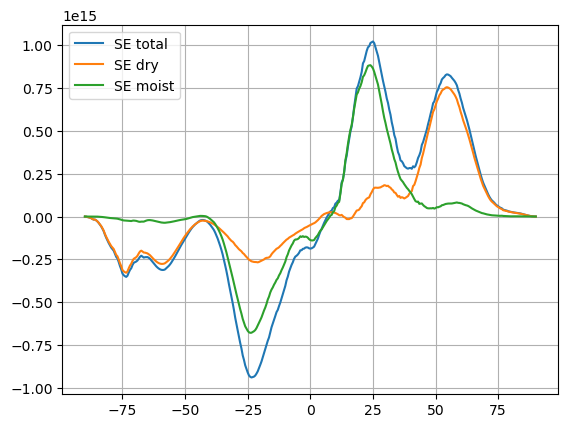

In [247]:
plt.plot(lats, se_vert * geometry, label='SE total')
plt.plot(lats, se_vert_dry * geometry, label='SE dry')
plt.plot(lats, se_vert_moist * geometry, label='SE moist')

plt.legend(loc=0)
plt.grid()
plt.show()

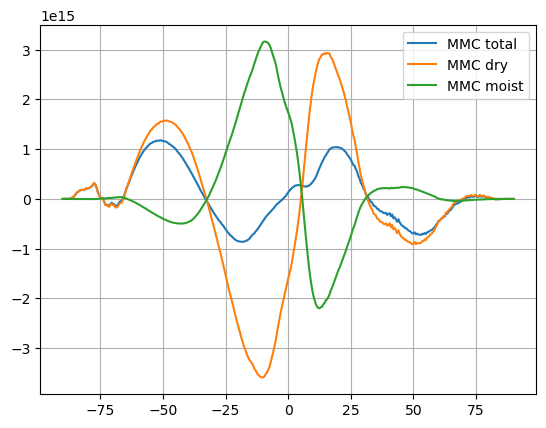

In [248]:
plt.plot(lats, moc_vert * geometry, label='MMC total')
plt.plot(lats, moc_vert_dry * geometry, label='MMC dry')
plt.plot(lats, moc_vert_moist * geometry, label='MMC moist')

plt.legend(loc=0)
plt.grid()
plt.show()

In [ ]:
def calc_heat_transport_sigma(datas):
    
    import numpy as np
    import xarray as xr
    import copy
    import metpy as mtp
    from metpy.interpolate import log_interpolate_1d
    
    #Switching so that this code takes in a xarray data file not a filename
    
    #home_direc='/data/tylersc/'
    #datas=xr.open_dataset(home_direc+file_name)
    
    #time=datas.time
    #lat=datas.lat
    #lon=datas.lon
    #pres=datas.pfull
    #pres_half=datas.phalf
    
    #datas=datas[dict(time=slice(len((time.values))//2,None))] #Taking only the second half of each run
    #new thought is to just take last 8 years of each run
    #datas=datas[dict(time=slice(-96,None))]
    
    #Constants
    a=6371220 #radius of earth in m
    L=2.5E6 #Latent heat in atmosphere
    L_ice=3.34e5 #Latent heat of fusion
    g=9.81 #Acceleration from gravity
    conv_pw=1e15 #Conversion from watts to PW
    cp=1004
    
    time=datas.time
    lat=datas.lat
    lon=datas.lon
    pres=datas.lev
    pres_half=datas.ilev
    p0=datas.P0[0] #THis has a time dimension but all are the same values

    #flux_sw=datas.flux_sw
    #flux_lw=datas.flux_lw
    #toa_rad=datas.FSNTOA
    
    solar_in=datas.SOLIN #Solar insolation (W/m^2), I believe this is at TOA
    solar_flx=datas.FSNT #Net solar flux at top of model (W/m^2)
    solar_out=solar_in-solar_flx #Solar flux out at the top of the model
    
    lwup_toa=datas.FLUT #Upwelling longwave flux at TOA
    
    #lwdn_surf=datas.lwdn_sfc
    #lwup_surf=datas.lwup_sfc
    #shflx=datas.shflx

    precip=(datas.PRECC+datas.PRECL)*L*1000
    evap=datas.LHFLX

    ps=datas.PS
    v_wind_old=datas.V
    sphum_old=datas.Q
    temp_old=datas.T
    height_old=datas.Z3

    
    #Get the weights for each layer-will include variations with latitude to account
    #for zonal differences in surface pressure

    weight=np.zeros((len(pres),len(lat)))

    ps_zonal=ps.mean(['time','lon']) #Surface pressure
    
    #Line below won't work until xarray is updated
    pres_half_new_bot=copy.deepcopy(pres_half.expand_dims({'lat':len(lat)},1).values)
    

    #making it so our pres_half bottom layer is surface pressure, not 1000hPa
    for i in range(0,len(lat),1):
        pres_half_new_bot[-1,i]=ps_zonal[i]/100
        weight[:,i]=np.diff(100*pres_half_new_bot[:,i])
        for k in range(0,len(pres),1):
            if weight[k,i] < 0:
                weight[k,i]=0
    
    
    #Alright so I am leaving weighting alone
    #I think it should still work fine, I just need to interpolate
    #All fields I am going to use from sigma to pressure
    #The actual pressure values at every grid/point are below
    
    pk=np.array([0.003643, 0.007595, 0.014357, 0.024612, 0.038268, 0.054595, 0.072012,
       0.087821, 0.103317, 0.121547, 0.142994, 0.168225, 0.178231, 0.170324,
       0.161023, 0.15008 , 0.137207, 0.122062, 0.104245, 0.084979, 0.066502,
       0.050197, 0.037189, 0.028432, 0.022209, 0.016407, 0.011075, 0.006255,
       0.001989, 0.      ])
    
    bk=np.array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.019677, 0.062504,
       0.112888, 0.172162, 0.241894, 0.323931, 0.420442, 0.5248  , 0.624888,
       0.713208, 0.78367 , 0.831103, 0.864811, 0.896237, 0.925124, 0.951231,
       0.974336, 0.992556])

    plevs = pres.values
    
    sigma_conv=np.zeros((len(time),len(pres),len(lat),len(lon)))
    
    v_wind=np.zeros((len(time),len(pres),len(lat),len(lon)))
    temp=np.zeros((len(time),len(pres),len(lat),len(lon)))
    height=np.zeros((len(time),len(pres),len(lat),len(lon)))
    sphum=np.zeros((len(time),len(pres),len(lat),len(lon)))
    
    
    for t in np.arange(0, len(time), 1):
        sigma_conv[t,:,:,:]=(np.multiply.outer(bk, ps.isel(time=t).values)+(pk)[:,None,None]*p0.values)/100 #Divide by 100 to convert to hPa
    
        #tdt_rad[t,:,:,:] = mtp.interpolate.log_interpolate_1d(plevs, sigma_conv[t,:,:,:], tdt_rad_old.isel(time=t), axis=0)
        v_wind[t,:,:,:] = log_interpolate_1d(plevs, sigma_conv[t,:,:,:], v_wind_old.isel(time=t), axis=0)
        temp[t,:,:,:] = log_interpolate_1d(plevs, sigma_conv[t,:,:,:], temp_old.isel(time=t), axis=0)
        height[t,:,:,:] = log_interpolate_1d(plevs, sigma_conv[t,:,:,:], height_old.isel(time=t), axis=0)
        sphum[t,:,:,:] = log_interpolate_1d(plevs, sigma_conv[t,:,:,:], sphum_old.isel(time=t), axis=0)
    
    #Now turn these numpy arrays into datarrays
    v_wind = xr.DataArray(v_wind, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat', 'lon'])
    temp = xr.DataArray(temp, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat_every', 'lon_every'])
    height = xr.DataArray(height, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat_every', 'lon_every'])
    sphum = xr.DataArray(sphum, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat', 'lon'])
    
    
    #Need to redefine weight so that it accounts for the nans
    
    nan_count=np.isnan(v_wind.mean(['time'])).sum(axis=2)
    nan_count=1-(nan_count/len(lon))
    weight=weight*nan_count.values
    
    #Result is a weight array of (level,lat)
    weight_aht=weight/g #This is needed for the units to work out for weight_aht
    
    #Calculate AHT without using TOA fluxes

    #tdt_rad_zonal=tdt_rad.mean(['time','lon'], skipna=True).values #Dims: (pres,lat)
    #tdt_rad_zonal_wgt=tdt_rad_zonal*weight_aht*cp

    #Summing them up    
    #vert_integral=np.nansum(tdt_rad_zonal_wgt, axis=0) #Dims: (lat)

    #Then add in the turbulent fluxes and we have someting we can zonally integrate
    #shflx_zonal=shflx.mean(['time','lon']) #Dims: (lat)
    #lhflx_zonal=evap.mean(['time','lon'])*L

    #total=vert_integral+shflx_zonal+lhflx_zonal #Dims: (lat)

    #Going to try just using OLR
    
    net_toa=(solar_in-solar_out-lwup_toa).mean(['time', 'lon']) #Dims: (lat)
    
    sfc_flx=(-datas.FLNS+datas.FSNS-datas.SHFLX-datas.LHFLX).mean(['time', 'lon'])
    snow=(datas.PRECSC+datas.PRECSL).mean(['time', 'lon'])*L_ice*1000
    sfc_flx=sfc_flx-snow
    
    total=net_toa-sfc_flx
    
    #Finding the mean to subtract
    total_mean= np.nansum(total*np.cos(lat*np.pi/180))/np.nansum(np.cos(lat*np.pi/180)) #Dims: (Single value)
    total_zonal=total-total_mean #Dims: (lat)

    #Latent heat part
    precip_zonal=precip.mean(['time','lon'])
    evap_zonal=evap.mean(['time','lon'])
    p_minus_e_zonal=precip_zonal-evap_zonal #Dims:(lat)

    #Now sum it over all the latitudes

    aht=np.zeros(len(lat))
    latent_energy=np.zeros(len(lat))
    for i in range(0,len(lat)-1,1):
        aht[i]=2*np.pi*a**2*np.trapz(-total_zonal[i:len(lat)],np.sin(lat[i:len(lat)]*np.pi/180)) #Dims:(lat)
        latent_energy[i]=2*np.pi*a**2*np.trapz((p_minus_e_zonal[i:len(lat)]),np.sin(lat[i:len(lat)]*np.pi/180))
    dry_energy=aht-latent_energy
    
    #And trying to break up aht into its various components

    #SE PART
    
    v_brack=v_wind.mean(['time','lon'], skipna=True) #Dims: (level,lat)
    temp_brack=temp.mean(['time','lon_every'], skipna=True)*cp
    height_brack=height.mean(['time','lon_every'], skipna=True)*g
    moist_brack=sphum.mean(['time','lon'], skipna=True)*L #Note the multiplying by constants

    v_brack_conf=v_brack.expand_dims({'lon':len(lon)},1) #Dims: (level,lat,lon)
    temp_brack_conf=temp_brack.expand_dims({'lon_every':len(lon)},1)
    height_brack_conf=height_brack.expand_dims({'lon_every':len(lon)},1)
    moist_brack_conf=moist_brack.expand_dims({'lon':len(lon)},1)
    

    v_star=v_wind.mean(['time'], skipna=True)-v_brack_conf #Dims: (level,lat,lon)
    temp_star=temp.mean(['time'], skipna=True)*cp-temp_brack_conf
    height_star=height.mean(['time'], skipna=True)*g-height_brack_conf
    moist_star=sphum.mean(['time'], skipna=True)*L-moist_brack_conf  #Note the multiplying by constants

    #Then multiply each together and average over lon
    #se_int=np.nanmean(v_star.values*mse_star.values,2) #Dims: (level,lat)
    se_int_t=np.nanmean(v_star.values*temp_star.values,2)
    se_int_z=np.nanmean(v_star.values*height_star.values,2)
    se_int_dry=np.nanmean(v_star.values*(temp_star.values+height_star.values),2)
    se_int_moist=np.nanmean(v_star.values*moist_star.values,2)
    se_int=se_int_dry+se_int_moist
    
    #MOC PART

    #Get the vertically averaged mse_brack_bar to then remove this value
    temp_brack_bar_vert=np.nanmean(temp.mean(['time','lon_every'], skipna=True)*cp*weight,0)/np.mean(weight,0) #Dims: (lat)
    height_brack_bar_vert=np.nanmean(height.mean(['time','lon_every'], skipna=True)*g*weight,0)/np.mean(weight,0)
    moist_brack_bar_vert=np.nanmean(sphum.mean(['time','lon'], skipna=True)*L*weight,0)/np.mean(weight,0)
    v_brack_bar_vert=np.nanmean(v_wind.mean(['time','lon'], skipna=True)*weight,0)/np.mean(weight,0)

    #Now add back in the level dimension so we can subtract it more easily
    temp_brack_bar_vert_conf=np.expand_dims(temp_brack_bar_vert,0) #Dims: (level,lat)
    height_brack_bar_vert_conf=np.expand_dims(height_brack_bar_vert,0)
    moist_brack_bar_vert_conf=np.expand_dims(moist_brack_bar_vert,0)
    v_brack_bar_vert_conf=np.expand_dims(v_brack_bar_vert,0)

    #Now calculate the zonal-time average v and mse and subtract out the vertical average for mse
    v_brack_bar=v_wind.mean(['time','lon'], skipna=True) - v_brack_bar_vert_conf #Dims: (level,lat)
    temp_brack_bar_final=temp.mean(['time','lon_every'], skipna=True)*cp - temp_brack_bar_vert_conf
    height_brack_bar_final=height.mean(['time','lon_every'], skipna=True)*g - height_brack_bar_vert_conf
    moist_brack_bar_final=sphum.mean(['time','lon'], skipna=True)*L - moist_brack_bar_vert_conf

    #Multiply the two to get our thing to integrate
    #moc_int=mse_brack_bar_final.values*v_brack_bar.values #Dims: (level,lat)
    moc_int_t=temp_brack_bar_final.values*v_brack_bar.values
    moc_int_z=height_brack_bar_final.values*v_brack_bar.values
    moc_int_dry=(temp_brack_bar_final.values+height_brack_bar_final.values)*v_brack_bar.values
    moc_int_moist=moist_brack_bar_final.values*v_brack_bar.values
    moc_int=moc_int_dry+moc_int_moist

    #Weighting each column
    se_int_wght=se_int*weight #Dims: (level,lat)
    se_int_wght_dry=se_int_dry*weight
    se_int_wght_moist=se_int_moist*weight
    se_int_wght_t=se_int_t*weight
    se_int_wght_z=se_int_z*weight
    moc_int_wght=moc_int*weight
    moc_int_wght_dry=moc_int_dry*weight
    moc_int_wght_moist=moc_int_moist*weight
    moc_int_wght_t=moc_int_t*weight
    moc_int_wght_z=moc_int_z*weight

    se_vert=np.nansum(se_int_wght, axis=0) #Dims: (lat)
    se_vert_dry=np.nansum(se_int_wght_dry, axis=0)
    se_vert_moist=np.nansum(se_int_wght_moist, axis=0)
    se_vert_t=np.nansum(se_int_wght_t, axis=0)
    se_vert_z=np.nansum(se_int_wght_z, axis=0)
    
    moc_vert=np.nansum(moc_int_wght, axis=0)
    moc_vert_dry=np.nansum(moc_int_wght_dry, axis=0)
    moc_vert_moist=np.nansum(moc_int_wght_moist, axis=0)
    moc_vert_t=np.nansum(moc_int_wght_t, axis=0)
    moc_vert_z=np.nansum(moc_int_wght_z, axis=0)

    coslat=np.cos(lat.values*np.pi/180)

    se=se_vert*np.pi*2*a*coslat/g #Dims: (lat)
    se_dry=se_vert_dry*np.pi*2*a*coslat/g
    se_moist=se_vert_moist*np.pi*2*a*coslat/g
    se_t=se_vert_t*np.pi*2*a*coslat/g
    se_z=se_vert_z*np.pi*2*a*coslat/g
    
    moc=moc_vert*np.pi*2*a*coslat/g 
    moc_dry=moc_vert_dry*np.pi*2*a*coslat/g 
    moc_moist=moc_vert_moist*np.pi*2*a*coslat/g
    moc_t=moc_vert_t*np.pi*2*a*coslat/g
    moc_z=moc_vert_z*np.pi*2*a*coslat/g

    #Then define the te and eddies for output
    te=aht-moc-se #transient part is the residual
    te_dry=dry_energy-moc_dry-se_dry
    te_moist=latent_energy-moc_moist-se_moist

    eddies=te+se
    eddies_dry=te_dry+se_dry
    eddies_moist=te_moist+se_moist
    
    return(aht, dry_energy, latent_energy, eddies, eddies_dry, eddies_moist, se, se_dry, se_moist, se_t, se_z, 
           te, te_dry, te_moist, moc, moc_dry, moc_moist, moc_t, moc_z, v_star, temp_star, height_star, moist_star, se_int_wght, se_int_wght_dry, se_int_wght_moist, se_int_wght_t, se_int_wght_z, 
           moc_int_wght, moc_int_wght_dry, moc_int_wght_moist, moc_int_wght_t, moc_int_wght_z, weight)


In [152]:
#Getting our initial half pressure levels

ps = merra_data.PS.mean('time')

pres_halfs = copy.deepcopy(levels[::-1])

pres_halfs_dif = (np.asarray(pres_halfs[1:]) + np.asarray(pres_halfs[:-1])) / 2
final_pres_halfs = xr.DataArray(np.append(np.insert(pres_halfs_dif,0,0), 1013))

#pres_half_new_bot= np.expand_dims(final_pres_halfs, axis=(1,2))#.astype(np.float32)
pres_half_new_bot=copy.deepcopy(final_pres_halfs.
                                expand_dims({'lat':len(lats)},1).expand_dims({'lon':len(lons)},-1).values)

#Now turn any levels below surface pressure to Nans
for k in range(0,len(final_pres_halfs),1):
    pres_half_new_bot[k,:,:][pres_half_new_bot[k,:,:] > ps.values/100]=np.nan
        #pres_half_new_bot[k,:,:][pres_half_new_bot[k,:,:] > ps/100]=np.nan

#Now get the index of the lowest non-nan level so we can turn it to surface pressure
low_level_index=(~np.isnan(pres_half_new_bot)).cumsum(0).argmax(0)

    #Make it so that if not the lowest level, the level is added to where the first nan is, not the first non-nan
low_level_index[low_level_index<(len(levels))] += 1
    #Now add the surface pressure
np.put_along_axis(pres_half_new_bot, low_level_index[None,:,:], (ps.values/100)[None,:,:], axis=0)
    #np.put_along_axis(pres_half_new_bot, low_level_index[None,:,:], (ps/100)[None,:,:], axis=0)

    #Now finite difference it to get weight
weight=np.diff(100*pres_half_new_bot, axis=0)

weight[weight<0]=np.nan   #Trying a nan here instead of 0

weight = weight[::-1,:,:]

In [233]:
#Getting our initial half pressure levels

ps = merra_data.PS.mean(['time', 'lon'])

pres_halfs = copy.deepcopy(levels[::-1])

pres_halfs_dif = (np.asarray(pres_halfs[1:]) + np.asarray(pres_halfs[:-1])) / 2
final_pres_halfs = xr.DataArray(np.append(np.insert(pres_halfs_dif,0,0), 1013))

#pres_half_new_bot= np.expand_dims(final_pres_halfs, axis=(1,2))#.astype(np.float32)
pres_half_new_bot=copy.deepcopy(final_pres_halfs.
                                expand_dims({'lat':len(lats)},1).values)

#Now turn any levels below surface pressure to Nans
for k in range(0,len(final_pres_halfs),1):
    pres_half_new_bot[k,:][pres_half_new_bot[k,:] > ps.values/100]=np.nan
        #pres_half_new_bot[k,:,:][pres_half_new_bot[k,:,:] > ps/100]=np.nan

#Now get the index of the lowest non-nan level so we can turn it to surface pressure
low_level_index=(~np.isnan(pres_half_new_bot)).cumsum(0).argmax(0)

    #Make it so that if not the lowest level, the level is added to where the first nan is, not the first non-nan
low_level_index[low_level_index<len(levels)] += 1
    #Now add the surface pressure
np.put_along_axis(pres_half_new_bot, low_level_index[None,:], (ps.values/100)[None,:], axis=0)
    #np.put_along_axis(pres_half_new_bot, low_level_index[None,:,:], (ps/100)[None,:,:], axis=0)

    #Now finite difference it to get weight
weight_zonal=np.diff(100*pres_half_new_bot, axis=0)

weight_zonal[weight_zonal<0]=np.nan   #Trying a nan here instead of 0

weight_zonal = weight_zonal[::-1,:]

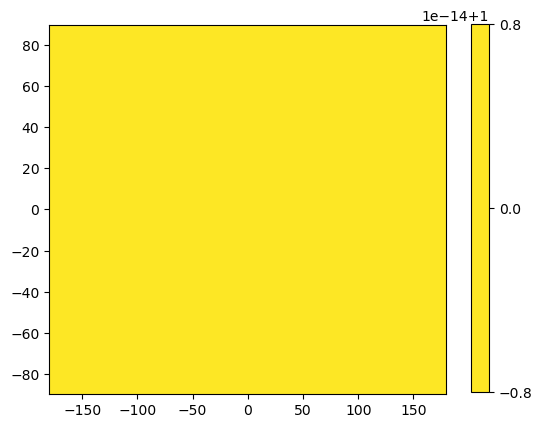

In [194]:
which_lev = 30

plt.contourf(lons, lats, weight[which_lev,:,:] / np.nanmax(weight[which_lev,:,:]), vmin=0, vmax=1, levels=30)

plt.colorbar()
plt.show()

<ipython-input-180-b80a9bc45736>:1: RuntimeWarning: Mean of empty slice
  plt.contourf(lats, levels, np.nanmean(weight, axis=2))


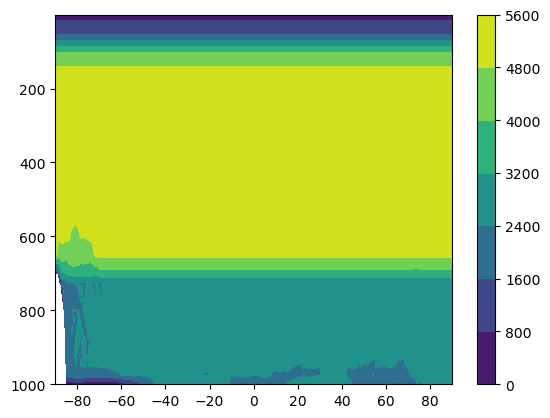

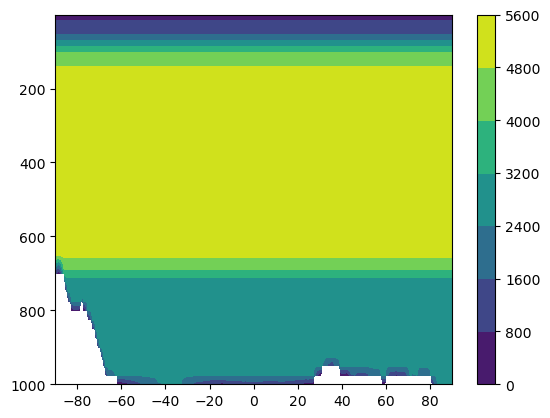

In [180]:
plt.contourf(lats, levels, np.nanmean(weight, axis=2))

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.contourf(lats, levels, weight_zonal)

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [181]:
zonal_sum = np.nansum(weight, axis=2)

zon_norm = weight/zonal_sum[:,:,None]

zon_norm[np.isnan(zon_norm)] = 0

weight_no_nan = copy.deepcopy(weight)
weight_no_nan[np.isnan(weight_no_nan)] = 0

#weight_zonal_ave = np.nanmean(weight, axis=2)

#weight_zonal_ave = np.sum(zon_norm * weight_no_nan, axis=2)

weight_zonal_ave = weight_zonal

In [196]:
#V_bar_brack = merra_data.V.mean(['time','lon'], skipna=True)
#T_bar_brack = merra_data.T.mean(['time','lon'], skipna=True) * cp
#Q_bar_brack = merra_data.QV.mean(['time','lon'], skipna=True) * L
#Z_bar_brack = merra_data.H.mean(['time','lon'], skipna=True) * g

V_bar_brack = (merra_data.V.mean(['time'], skipna=True) * zon_norm).sum(['lon'])
T_bar_brack = (merra_data.T.mean(['time'], skipna=True) * zon_norm).sum(['lon']) * cp
Q_bar_brack = (merra_data.QV.mean(['time'], skipna=True) * zon_norm).sum(['lon']) * L
Z_bar_brack = (merra_data.H.mean(['time'], skipna=True) * zon_norm).sum(['lon']) * g

V_bar = merra_data.V.mean(['time'], skipna=True)
T_bar = merra_data.T.mean(['time'], skipna=True) * cp
Q_bar = merra_data.QV.mean(['time'], skipna=True) * L
Z_bar = merra_data.H.mean(['time'], skipna=True) * g

In [197]:
V_se = merra_data.V.mean(['time'], skipna=True) - V_bar_brack
T_se = merra_data.T.mean(['time'], skipna=True) * cp - T_bar_brack
Q_se = merra_data.QV.mean(['time'], skipna=True) * L - Q_bar_brack
Z_se = merra_data.H.mean(['time'], skipna=True) * g - Z_bar_brack

In [198]:
VT_se = V_se * T_se * weight
VQ_se = V_se * Q_se * weight
VZ_se = V_se * Z_se * weight

In [199]:
VT_te = ((merra_data.Cov_V_T.mean(['time'], skipna=True) * cp) - (V_bar * T_bar)) * weight
VQ_te = ((merra_data.Cov_V_QV.mean(['time'], skipna=True) * L) - (V_bar * Q_bar)) * weight
VZ_te = ((merra_data.Cov_V_H.mean(['time'], skipna=True) * g) - (V_bar * Z_bar)) * weight

In [200]:
V_bar_brack_vert_ave = np.nansum(V_bar_brack * weight_zonal_ave, axis=0) / np.nansum(weight_zonal_ave, axis=0)
T_bar_brack_vert_ave = np.nansum(T_bar_brack * weight_zonal_ave, axis=0) / np.nansum(weight_zonal_ave, axis=0)
Q_bar_brack_vert_ave = np.nansum(Q_bar_brack * weight_zonal_ave, axis=0) / np.nansum(weight_zonal_ave, axis=0)
Z_bar_brack_vert_ave = np.nansum(Z_bar_brack * weight_zonal_ave, axis=0) / np.nansum(weight_zonal_ave, axis=0)

#V_mmc = V_bar_brack - np.expand_dims(V_bar_brack_vert_ave, 0)
V_mmc = V_bar_brack - V_bar_brack_vert_ave
T_mmc = T_bar_brack - T_bar_brack_vert_ave
Q_mmc = Q_bar_brack - Q_bar_brack_vert_ave
Z_mmc = Z_bar_brack - Z_bar_brack_vert_ave

In [201]:
VT_mmc = (V_mmc * T_mmc) * weight_zonal_mean
VQ_mmc = (V_mmc * Q_mmc) * weight_zonal_mean
VZ_mmc = (V_mmc * Z_mmc) * weight_zonal_mean

In [203]:
#se_T = VT_se.sum(['lev'], skipna=True).mean(['lon'], skipna=True)
#se_Q = VQ_se.sum(['lev'], skipna=True).mean(['lon'], skipna=True)
#se_Z = VZ_se.sum(['lev'], skipna=True).mean(['lon'], skipna=True)

se_T = (VT_se * zon_norm).sum(['lev', 'lon'], skipna=True)
se_Q = (VQ_se * zon_norm).sum(['lev', 'lon'], skipna=True)
se_Z = (VZ_se * zon_norm).sum(['lev', 'lon'], skipna=True)

In [204]:
#te_T = VT_te.sum(['lev'], skipna=True).mean(['lon'], skipna=True)
#te_Q = VQ_te.sum(['lev'], skipna=True).mean(['lon'], skipna=True)
#te_Z = VZ_te.sum(['lev'], skipna=True).mean(['lon'], skipna=True)

te_T = (VT_te * zon_norm).sum(['lev', 'lon'], skipna=True)
te_Q = (VQ_te * zon_norm).sum(['lev', 'lon'], skipna=True)
te_Z = (VZ_te * zon_norm).sum(['lev', 'lon'], skipna=True)

In [205]:
mmc_T = VT_mmc.sum(['lev'], skipna=True)
mmc_Q = VQ_mmc.sum(['lev'], skipna=True)
mmc_Z = VZ_mmc.sum(['lev'], skipna=True)

In [206]:
se_T.compute()
se_Q.compute()
se_Z.compute()

<xarray.DataArray (lat: 361)>
array([-1.74582571e-14, -7.50777393e+04,  2.12607020e+05,  1.13029017e+06,
        3.55190285e+05, -5.21107846e+05, -2.27627065e+06, -3.48659926e+06,
       -1.84939168e+06, -8.57070914e+05, -2.62197616e+06, -1.42529860e+06,
       -2.09558468e+06, -9.42557436e+05, -1.49673725e+05, -1.04294473e+05,
        4.39739075e+05,  9.70050557e+05,  1.62909535e+06,  3.03084162e+06,
        3.49650891e+06,  4.17418481e+06,  3.87818649e+06,  4.43749383e+06,
        5.05400698e+06,  6.12146786e+06,  6.61199049e+06,  7.09995122e+06,
        7.36724981e+06,  7.18437955e+06,  7.83488919e+06,  8.23112282e+06,
        8.29897933e+06,  8.15794784e+06,  8.09290820e+06,  8.15124383e+06,
        8.34931204e+06,  8.69369109e+06,  8.74196240e+06,  8.67976109e+06,
        8.30244290e+06,  7.85661962e+06,  7.24472046e+06,  7.03808820e+06,
        6.61918276e+06,  6.09901902e+06,  5.59619201e+06,  5.11357791e+06,
        4.57477042e+06,  4.03156035e+06,  3.62459132e+06,  3.25868210e+06,
        3.16961070e+06,  2.92361560e+06,  2.81802054e+06,  2.72747343e+06,
        2.68261525e+06,  2.66087799e+06,  2.65257479e+06,  2.65859979e+06,
        2.66348052e+06,  2.66149310e+06,  2.66466465e+06,  2.64880377e+06,
        2.62745309e+06,  2.58888055e+06,  2.54098441e+06,  2.48317659e+06,
        2.39976632e+06,  2.35649948e+06,  2.25088528e+06,  2.18349776e+06,
        2.10969252e+06,  1.99603978e+06,  1.92323004e+06,  1.80048601e+06,
        1.70342921e+06,  1.61059966e+06,  1.45173726e+06,  1.40002285e+06,
...
       -8.16887405e+06, -7.85461780e+06, -7.40091564e+06, -7.15208923e+06,
       -6.71756618e+06, -6.27928869e+06, -5.91351553e+06, -5.50075104e+06,
       -5.14972382e+06, -4.85060230e+06, -4.30854462e+06, -4.06038956e+06,
       -3.75816276e+06, -3.35651569e+06, -3.12235149e+06, -2.74478004e+06,
       -2.41056564e+06, -1.94408109e+06, -1.69314815e+06, -1.32651717e+06,
       -9.53876012e+05, -7.34830340e+05, -4.24204266e+05,  2.01299814e+03,
        3.06384513e+05,  6.45303515e+05,  7.91638921e+05,  9.61934341e+05,
        1.25610699e+06,  1.31208662e+06,  1.71586108e+06,  1.82283005e+06,
        2.12431520e+06,  2.09032475e+06,  2.24424643e+06,  2.19049359e+06,
        2.21821553e+06,  2.21179344e+06,  2.09780081e+06,  2.19331406e+06,
        2.16528760e+06,  1.99748821e+06,  2.18144844e+06,  1.99101693e+06,
        1.97667481e+06,  2.07753202e+06,  2.02921464e+06,  1.88444416e+06,
        1.87616462e+06,  1.67538515e+06,  1.65426675e+06,  1.48880817e+06,
        1.59844798e+06,  1.38695084e+06,  1.44747594e+06,  1.33915526e+06,
        1.24263320e+06,  1.24039040e+06,  1.03157872e+06,  1.00392733e+06,
        8.73315841e+05,  7.91543948e+05,  6.82803897e+05,  5.64732545e+05,
        4.13730298e+05,  3.18138406e+05,  2.32253106e+05,  1.59042166e+05,
        1.08036278e+05,  6.33767775e+04,  3.79575614e+04,  1.37351482e+04,
        6.92215289e+03, -1.61594484e+03,  2.44984605e+03, -3.05976844e+03,
       -7.22078647e-16])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [207]:
te_T.compute()
te_Q.compute()
te_Z.compute()

<xarray.DataArray (lat: 361)>
array([ 2.60321333e+02, -1.29642666e+07,  2.61278969e+07,  6.95759896e+07,
        7.19751727e+07,  3.66080442e+07, -3.19960434e+07, -1.21721969e+08,
       -1.54581840e+08, -8.77914526e+07, -3.11056593e+07,  1.97931610e+07,
        9.42445007e+07,  1.47153693e+08,  1.88875448e+08,  2.42361032e+08,
        2.66331201e+08,  3.13371158e+08,  3.44776136e+08,  3.60980619e+08,
        3.94163094e+08,  4.25982856e+08,  4.33678286e+08,  4.34901957e+08,
        4.45515984e+08,  4.53812762e+08,  4.55992883e+08,  4.79785402e+08,
        4.92949104e+08,  5.01886279e+08,  5.01230556e+08,  5.09865632e+08,
        5.33091659e+08,  5.26767255e+08,  5.18418062e+08,  5.45236814e+08,
        5.60105595e+08,  5.49014876e+08,  5.66080118e+08,  5.60049047e+08,
        5.45574882e+08,  5.19806828e+08,  5.00166750e+08,  4.73910399e+08,
        4.43563218e+08,  4.08168045e+08,  3.36881775e+08,  2.66221972e+08,
        1.81461490e+08,  1.02675471e+08,  1.80478668e+07, -6.72699543e+07,
       -1.57438159e+08, -2.34374308e+08, -3.10348310e+08, -3.81264270e+08,
       -4.50888112e+08, -5.15215180e+08, -5.78933781e+08, -6.37416761e+08,
       -6.94693151e+08, -7.48361984e+08, -7.98657711e+08, -8.46560594e+08,
       -8.90384959e+08, -9.31782979e+08, -9.70109994e+08, -1.00660803e+09,
       -1.03931310e+09, -1.07235409e+09, -1.10092299e+09, -1.12758110e+09,
       -1.15059501e+09, -1.17001220e+09, -1.18933685e+09, -1.20449103e+09,
       -1.21719058e+09, -1.22918808e+09, -1.23695713e+09, -1.24586337e+09,
...
        7.34157848e+08,  7.16331877e+08,  6.97721095e+08,  6.81938216e+08,
        6.64891978e+08,  6.44008385e+08,  6.13085953e+08,  5.99200142e+08,
        5.75225222e+08,  5.47852037e+08,  5.21199440e+08,  4.94330395e+08,
        4.59996392e+08,  4.20683785e+08,  3.83632858e+08,  3.46830702e+08,
        3.02793770e+08,  2.62542187e+08,  2.36006037e+08,  2.05929318e+08,
        1.82375428e+08,  1.42886367e+08,  1.09458670e+08,  8.00571207e+07,
        5.99090709e+07,  3.07696726e+07, -1.26821580e+06, -2.59321370e+07,
       -6.16563827e+07, -8.30653630e+07, -1.11338567e+08, -1.44096483e+08,
       -1.65937516e+08, -1.82211901e+08, -2.03379627e+08, -2.06303177e+08,
       -2.22368443e+08, -2.16680085e+08, -2.26801002e+08, -2.26354930e+08,
       -2.33046072e+08, -2.27356748e+08, -2.10782104e+08, -2.17290380e+08,
       -2.11318444e+08, -2.00138030e+08, -1.88877966e+08, -1.88316985e+08,
       -1.82884191e+08, -1.79924401e+08, -1.67105109e+08, -1.49468736e+08,
       -1.35979729e+08, -1.15542501e+08, -9.79947547e+07, -8.81572214e+07,
       -7.00962553e+07, -5.62739309e+07, -2.80588478e+07, -1.27973043e+07,
       -7.08335512e+06,  3.11186169e+05,  1.80511924e+07,  2.05595593e+07,
        2.68878722e+07,  2.48814817e+07,  2.78130979e+07,  2.32098742e+07,
        2.22689572e+07,  1.93206646e+07,  1.56194923e+07,  1.34927063e+07,
        8.00472257e+06,  7.47555460e+06,  3.20539034e+06,  5.17704184e+06,
        4.97708815e+02])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [208]:
mmc_T.compute()
mmc_Q.compute()
mmc_Z.compute()

<xarray.DataArray (lat: 361)>
array([ 8.95852695e+01, -6.42267834e+06,  6.95103084e+07,  8.17452812e+07,
        7.56539435e+07, -3.51062404e+06, -8.41756950e+07, -3.97839525e+08,
       -8.27642065e+08, -1.54912637e+09, -3.16261159e+09, -3.86325221e+09,
       -3.44411272e+09, -3.31788019e+09, -3.14659316e+09, -2.86724717e+09,
       -2.68897434e+09, -2.74981162e+09, -2.49952372e+09, -2.63632299e+09,
       -2.74325576e+09, -2.98995815e+09, -3.32053916e+09, -3.39229925e+09,
       -3.66338317e+09, -3.43391983e+09, -3.02941418e+09, -2.71095253e+09,
       -2.59497029e+09, -2.08153143e+09, -1.83351560e+09, -1.65123763e+09,
       -1.53168118e+09, -1.45562103e+09, -1.18235234e+09, -1.05783094e+09,
       -1.03433564e+09, -1.05048426e+09, -1.02428404e+09, -9.95223221e+08,
       -9.55108090e+08, -8.60622649e+08, -7.55412860e+08, -6.50003640e+08,
       -5.70305983e+08, -5.01426365e+08, -3.96185429e+08, -3.58551218e+08,
       -2.68032204e+08, -1.63662970e+08, -4.28494994e+07,  7.22318749e+07,
        1.68019942e+08,  2.67280395e+08,  3.54778230e+08,  4.30973030e+08,
        5.08864417e+08,  5.77773671e+08,  6.48210850e+08,  7.10670989e+08,
        7.73370686e+08,  8.29652971e+08,  8.82109743e+08,  9.17050727e+08,
        9.42939068e+08,  9.82441239e+08,  1.01638297e+09,  1.04711008e+09,
        1.07375886e+09,  1.10890242e+09,  1.15251841e+09,  1.17712782e+09,
        1.20619015e+09,  1.22930954e+09,  1.24805843e+09,  1.27812154e+09,
        1.29090143e+09,  1.31066271e+09,  1.33272787e+09,  1.34194570e+09,
...
       -1.01079120e+09, -9.84214472e+08, -9.48842628e+08, -9.06515479e+08,
       -8.82839217e+08, -8.34649720e+08, -8.09109759e+08, -7.53697621e+08,
       -7.32678783e+08, -6.82015978e+08, -6.46388220e+08, -5.99362238e+08,
       -5.47662511e+08, -4.88971861e+08, -4.12978054e+08, -3.55103169e+08,
       -2.82409707e+08, -2.36261043e+08, -1.81730324e+08, -1.29362653e+08,
       -8.32073644e+07, -4.83418289e+07,  2.66983634e+07,  4.05547948e+07,
        2.53360324e+07,  7.21643149e+07,  1.16316914e+08,  1.49969936e+08,
        1.75986120e+08,  1.73221393e+08,  2.30407309e+08,  3.75729275e+08,
        4.02117496e+08,  3.99593239e+08,  4.07628917e+08,  3.76609337e+08,
        3.37964524e+08,  3.17903253e+08,  3.19862141e+08,  3.14234904e+08,
        3.10379796e+08,  2.88363071e+08,  3.11257098e+08,  2.69175719e+08,
        2.63801005e+08,  2.82569280e+08,  2.73840724e+08,  2.41996508e+08,
        2.21129063e+08,  2.41158590e+08,  1.98524619e+08,  2.02062100e+08,
        2.15767124e+08,  1.59684033e+08,  1.52641113e+08,  1.46156132e+08,
        1.22871594e+08,  8.36175200e+07,  4.85925234e+07,  2.74180048e+07,
        4.22789182e+06, -1.84707997e+07, -4.20267063e+07, -2.12582995e+07,
       -3.47746068e+07, -2.19874644e+07, -2.48518389e+07, -1.85942892e+07,
       -1.59839755e+07, -1.48597659e+07, -1.09854995e+07, -1.22763787e+07,
       -8.12720273e+06, -9.59753691e+06, -4.47689845e+06, -9.96499649e+06,
       -9.42278508e+01])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

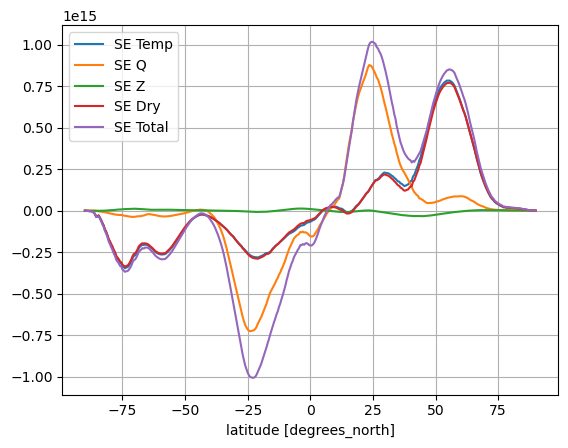

In [209]:
(se_T * geometry).plot(label='SE Temp')
(se_Q * geometry).plot(label='SE Q')
(se_Z * geometry).plot(label='SE Z')
((se_T + se_Z) * geometry).plot(label='SE Dry')
((se_T + se_Z + se_Q) * geometry).plot(label='SE Total')

plt.legend(loc=0)
plt.grid()
plt.show()

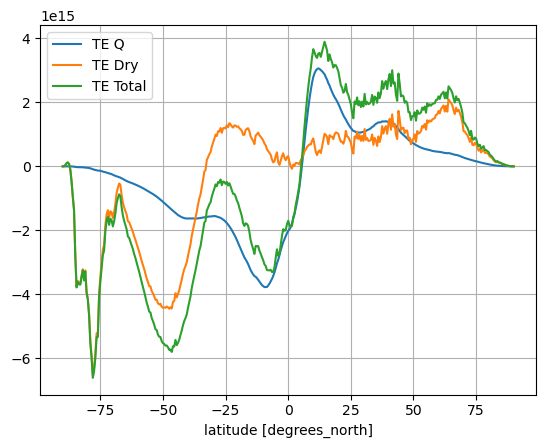

In [212]:
#(te_T * geometry).plot(label='TE Temp')
(te_Q * geometry).plot(label='TE Q')
#(te_Z * geometry).plot(label='TE Z')
((te_T + te_Z) * geometry).plot(label='TE Dry')
((te_T + te_Z + te_Q) * geometry).plot(label='TE Total')

plt.legend(loc=0)
plt.grid()
plt.show()

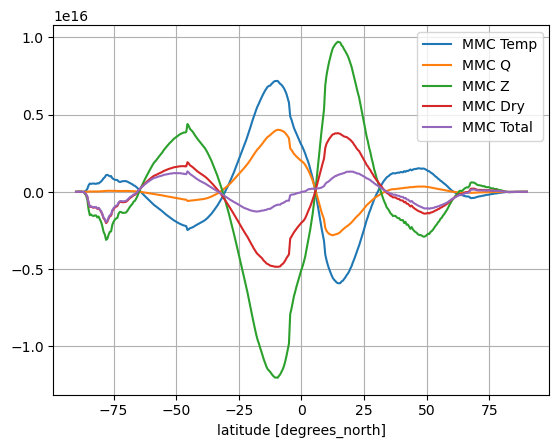

In [211]:
(mmc_T * geometry).plot(label='MMC Temp')
(mmc_Q * geometry).plot(label='MMC Q')
(mmc_Z * geometry).plot(label='MMC Z')
((mmc_T + mmc_Z) * geometry).plot(label='MMC Dry')
((mmc_T + mmc_Z + mmc_Q) * geometry).plot(label='MMC Total')

plt.legend(loc=0)

plt.grid()

plt.show()

In [ ]:
def aht_weights():
    '''Gets the time invariant weighting for the AHT calculation
    
    Agrs:
        None
    
    Returns:
        -weight (array-like): Time-invariant array of the vertical weighting for AHT (coords of level, lat, lon)
    
    '''
    
    #load in the surface pressure
    ps = xr.open_dataset('aht_calcs/monthly_ps.nc')
    #aarons ps
    #aarons_ps = io.loadmat('aaron_aht_stuff/CLIM_PS.mat', verify_compressed_data_integrity=False)
    #ps = aarons_ps['CPS']
    
    #Load in the era5 data to get the proper lat/lon and levels
    dummy_era5_data = xr.open_dataset('/home/disk/eos9/ERA5/hourly_pl/00/1985.v.nc')
    
    lat = dummy_era5_data.latitude
    lon = dummy_era5_data.longitude
    
    new_coords = xr.Dataset({'lat': (['lat'], dummy_era5_data.latitude.values),
                         'lon': (['lon'], dummy_era5_data.longitude.values),
                        }
                       )

    regridder = xe.Regridder(ps, new_coords, 'bilinear')

    # the entire dataset can be processed at once
    new_ps = regridder(ps)
    
    ps=new_ps.sp.mean(['time']).sel(expver=1) #Surface pressure

    

    #Getting our initial half pressure levels
    pres_halfs = copy.deepcopy(dummy_era5_data.level.values)

    pres_halfs_dif = (np.asarray(pres_halfs[1:]) + np.asarray(pres_halfs[:-1])) / 2
    final_pres_halfs = xr.DataArray(np.append(np.insert(pres_halfs_dif,0,0), 1013))

    #pres_half_new_bot= np.expand_dims(final_pres_halfs, axis=(1,2))#.astype(np.float32)
    pres_half_new_bot=copy.deepcopy(final_pres_halfs.
                                        expand_dims({'lat':len(lat)},1).expand_dims({'lon':len(lon)},-1).values)

    #Now turn any levels below surface pressure to Nans
    for k in range(0,len(final_pres_halfs),1):
        pres_half_new_bot[k,:,:][pres_half_new_bot[k,:,:] > ps.values/100]=np.nan
        #pres_half_new_bot[k,:,:][pres_half_new_bot[k,:,:] > ps/100]=np.nan

    #Now get the index of the lowest non-nan level so we can turn it to surface pressure
    low_level_index=(~np.isnan(pres_half_new_bot)).cumsum(0).argmax(0)

    #Make it so that if not the lowest level, the level is added to where the first nan is, not the first non-nan
    low_level_index[low_level_index<37] += 1
    #Now add the surface pressure
    np.put_along_axis(pres_half_new_bot, low_level_index[None,:,:], (ps.values/100)[None,:,:], axis=0)
    #np.put_along_axis(pres_half_new_bot, low_level_index[None,:,:], (ps/100)[None,:,:], axis=0)

    #Now finite difference it to get weight
    weight=np.diff(100*pres_half_new_bot, axis=0)

    weight[weight<0]=np.nan   #Trying a nan here instead of 0
    
    return weight

def zonal_norm(weight):
    '''Makes zonal norms that helps take weights in aht_instant
    Args:
        -weight(array): Array of vertical weights from aht_weights
        
    Returns:
        -zon_norm(array): Zonal norms to be used in aht_instant to take zonal averages
    '''
    
    zonal_sum = np.nansum(weight, axis=2)

    zon_norm = weight/zonal_sum[:,:,None]

    zon_norm[np.isnan(zon_norm)] = 0
    
    return zon_norm

In [ ]:
def calc_heat_transport_sigma(datas, use_tdt_rad=False):
    '''Calculates meridional heat transport using data in sigma coordinates
    Args:
        datas (xarray dataset)- A GRaM output dataset as an xarray dataset
        use_tdt_rad (Boolean, default=False)- Whether to use TOA radiation or vertically integrated radiative temperature tendency
    Output:
        aht- total aht
        dry_energy- dry  (DSE) aht
        latent_energy- moist (latent only)aht
        eddies- TE and SE aht
        eddies_dry- TE and SE DSE AHT
        eddies_moist- TE and SE latent AHT
        se- SE total AHT
        se_dry- SE DSE AHT
        se_moist- SE latent AHT
        te- TE total AHT
        te_dry- TE DSE AHT
        te_moist- TE latent AHT
        mmc- MMC total AHT
        mmc_dry- MMC DSE AHT
        v_star- Zonally anomalous meridional wind
        mse_star- Zonally anomalous mse
        dse_star- Zonally anomalous dse
        moist_star- Zonally anomalous specific humidity * L
    '''
    
    import numpy as np
    import xarray as xr
    import copy
    import metpy as mtp
    from scipy import integrate
    
    time=datas.time
    lat=datas.lat
    lon=datas.lon
    pres=datas.pfull
    pres_half=datas.phalf

    flux_sw=datas.flux_sw
    flux_lw=datas.flux_lw
    lwflx=datas.lwflx
    toa_flux_rad=-datas.flux_rad.isel(phalf=0)
    lwdn_surf=datas.lwdn_sfc
    lwup_surf=datas.lwup_sfc
    shflx=datas.shflx

    precip=datas.precip
    evap=datas.evap

    ps=datas.ps
    t_surf=datas.t_surf
    v_wind_old=datas.vcomp
    sphum_old=datas.sphum
    temp_old=datas.temp
    mse_old=datas.moist_stat_en
    dse_old=datas.dry_stat_en
    tdt_rad_old=datas.tdt_rad
    
    #Constants
    a=6371220 #radius of earth in m
    L=2.5E6 #Latent heat in atmosphere
    g=9.81 #Acceleration from gravity
    conv_pw=1e15 #Conversion from watts to PW
    cp=1007
    
    weight=np.zeros((len(pres),len(lat)))

    ps_zonal=ps.mean(['time','lon']) #Surface pressure
    
    pres_half_new_bot=copy.deepcopy(pres_half.expand_dims({'lat':len(lat)},1).values)

    #making it so our pres_half bottom layer is surface pressure, not 1000hPa
    for i in range(0,len(lat),1):
        pres_half_new_bot[-1,i]=ps_zonal[i]/100
        weight[:,i]=np.diff(100*pres_half_new_bot[:,i])
        for k in range(0,len(pres),1):
            if weight[k,i] < 0:
                weight[k,i]=0
    
    bk=pres/1000
    bk_half=pres_half/1000
    
    plevs = pres.values #Desired levels to interpolate to
    plevs_half = pres_half.values #Desired levels to interpolate to 
    
    sigma_conv=np.zeros((len(time),len(pres),len(lat),len(lon)))
    sigma_conv_half=np.zeros((len(time),len(pres_half),len(lat),len(lon)))
    tdt_rad=np.zeros((len(time),len(pres),len(lat),len(lon)))
    v_wind=np.zeros((len(time),len(pres),len(lat),len(lon)))
    mse=np.zeros((len(time),len(pres),len(lat),len(lon)))
    dse=np.zeros((len(time),len(pres),len(lat),len(lon)))
    sphum=np.zeros((len(time),len(pres),len(lat),len(lon)))
    
    
    for t in np.arange(0, len(time), 1):
        sigma_conv[t,:,:,:]=np.multiply.outer(bk.values, ps.isel(time=t).values)/100 #Divide by 100 to convert to hPa
        sigma_conv_half[t,:,:,:]=np.multiply.outer(bk_half.values, ps.isel(time=t).values)/100 #Divide by 100 to convert to hPa
        v_wind[t,:,:,:] = mtp.interpolate.log_interpolate_1d(plevs, sigma_conv[t,:,:,:], v_wind_old.isel(time=t), axis=0)
        mse[t,:,:,:] = mtp.interpolate.log_interpolate_1d(plevs, sigma_conv[t,:,:,:], mse_old.isel(time=t), axis=0)
        dse[t,:,:,:] = mtp.interpolate.log_interpolate_1d(plevs, sigma_conv[t,:,:,:], dse_old.isel(time=t), axis=0)
        sphum[t,:,:,:] = mtp.interpolate.log_interpolate_1d(plevs, sigma_conv[t,:,:,:], sphum_old.isel(time=t), axis=0)
        if use_tdt_rad == True:
            tdt_rad[t,:,:,:] = mtp.interpolate.log_interpolate_1d(plevs, sigma_conv[t,:,:,:], tdt_rad_old.isel(time=t), axis=0)
        else:
            pass
    
    #Now turn these numpy arrays into datarrays
    
    tdt_rad = xr.DataArray(tdt_rad, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat', 'lon'])
    v_wind = xr.DataArray(v_wind, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat', 'lon'])
    mse = xr.DataArray(mse, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat_every', 'lon_every'])
    dse = xr.DataArray(dse, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat_every', 'lon_every'])
    sphum = xr.DataArray(sphum, coords=[time, pres, lat, lon], dims=['time', 'pfull', 'lat', 'lon'])
    
    #Need to redefine weight so that it accounts for the nans
    nan_count=np.isnan(v_wind.mean(['time'])).sum(axis=2)
    nan_count=1-(nan_count/len(lon))
    weight=weight*nan_count.values
    
    #Result is a weight array of (level,lat)
    weight_aht=weight/g #This is needed for the units to work out for weight_aht
    
    if use_tdt_rad==True:
        
        #Calculate AHT without using TOA fluxes

        tdt_rad_zonal=tdt_rad.mean(['time','lon'], skipna=True).values #Dims: (pres,lat)
        tdt_rad_zonal_wgt=tdt_rad_zonal*weight_aht*cp

        #Summing them up    
        vert_integral=np.nansum(tdt_rad_zonal_wgt, axis=0) #Dims: (lat)

        #Then add in the turbulent fluxes and we have someting we can zonally integrate
        shflx_zonal=shflx.mean(['time','lon']) #Dims: (lat)
        lhflx_zonal=evap.mean(['time','lon'])*L

        total=vert_integral+shflx_zonal+lhflx_zonal #Dims: (lat)
        
        #Finding the mean to subtract
        total_mean= sum(total*np.cos(lat*np.pi/180))/sum(np.cos(lat*np.pi/180)) #Dims: (Single value)
        total_zonal=total-total_mean #Dims: (lat)
    
    elif use_tdt_rad==False:
        sfc_flx=(-datas.lwdn_sfc+datas.lwup_sfc+datas.flux_sw.isel(phalf=-1)+datas.shflx+datas.evap*L).mean(['time', 'lon'])
        total=toa_flux_rad.mean(['time','lon'])-sfc_flx #Dims: (lat)

        #Finding the mean to subtract
        total_mean= np.nansum(total*np.cos(lat*np.pi/180))/np.nansum(np.cos(lat*np.pi/180)) #Dims: (Single value)
        total_zonal=total-total_mean #Dims: (lat)
    else:
        pass

    #Latent heat part
    precip_zonal=precip.mean(['time','lon'])
    evap_zonal=evap.mean(['time','lon'])
    p_minus_e_zonal=precip_zonal-evap_zonal #Dims:(lat)

    #Now sum it over all the latitudes
    aht_integ = integrate.cumtrapz(total_zonal, x=np.sin(lat*np.pi/180), initial=0)
    aht = 2*np.pi*a**2*aht_integ
    
    latent_integ = integrate.cumtrapz(-p_minus_e_zonal, x=np.sin(lat*np.pi/180), initial=0)
    latent_energy = 2*np.pi*a**2*latent_integ*L
    dry_energy=aht-latent_energy
    
    #And trying to break up aht into its various components

    #SE PART
    
    v_brack=v_wind.mean(['time','lon'], skipna=True) #Dims: (level,lat)
    mse_brack=mse.mean(['time','lon_every'], skipna=True)
    dse_brack=dse.mean(['time','lon_every'], skipna=True)
    moist_brack=sphum.mean(['time','lon'], skipna=True)*L

    v_brack_conf=v_brack.expand_dims({'lon':len(lon)},1) #Dims: (level,lat,lon)
    mse_brack_conf=mse_brack.expand_dims({'lon_every':len(lon)},1)
    dse_brack_conf=dse_brack.expand_dims({'lon_every':len(lon)},1)
    moist_brack_conf=moist_brack.expand_dims({'lon':len(lon)},1)
    

    v_star=v_wind.mean(['time'], skipna=True)-v_brack_conf #Dims: (level,lat,lon)
    mse_star=mse.mean(['time'], skipna=True)-mse_brack_conf
    dse_star=dse.mean(['time'], skipna=True)-dse_brack_conf
    moist_star=sphum.mean(['time'], skipna=True)*L-moist_brack_conf

    #Then multiply each together and average over lon
    se_int=np.nanmean(v_star.values*mse_star.values,2) #Dims: (level,lat)
    se_int_dry=np.nanmean(v_star.values*dse_star.values,2)
    se_int_moist=np.nanmean(v_star.values*moist_star.values,2)

    #MOC PART

    #Get the vertically averaged mse_brack_bar to then remove this value
    mse_brack_bar_vert=np.nanmean(mse.mean(['time','lon_every'], skipna=True)*weight,0)/np.mean(weight,0) #Dims: (lat)
    dse_brack_bar_vert=np.nanmean(dse.mean(['time','lon_every'], skipna=True)*weight,0)/np.mean(weight,0)
    moist_brack_bar_vert=np.nanmean(sphum.mean(['time','lon'], skipna=True)*L*weight,0)/np.mean(weight,0)
    v_brack_bar_vert=np.nanmean(v_wind.mean(['time','lon'], skipna=True)*weight,0)/np.mean(weight,0)

    #Now add back in the level dimension so we can subtract it more easily
    mse_brack_bar_vert_conf=np.expand_dims(mse_brack_bar_vert,0) #Dims: (level,lat)
    dse_brack_bar_vert_conf=np.expand_dims(dse_brack_bar_vert,0)
    moist_brack_bar_vert_conf=np.expand_dims(moist_brack_bar_vert,0)
    v_brack_bar_vert_conf=np.expand_dims(v_brack_bar_vert,0)

    #Now calculate the zonal-time average v and mse and subtract out the vertical average for mse
    v_brack_bar=v_wind.mean(['time','lon'], skipna=True) - v_brack_bar_vert_conf #Dims: (level,lat)
    mse_brack_bar_final=mse.mean(['time','lon_every'], skipna=True) - mse_brack_bar_vert_conf
    dse_brack_bar_final=dse.mean(['time','lon_every'], skipna=True) - dse_brack_bar_vert_conf
    moist_brack_bar_final=sphum.mean(['time','lon'], skipna=True)*L - moist_brack_bar_vert_conf

    #Multiply the two to get our thing to integrate
    moc_int=mse_brack_bar_final.values*v_brack_bar.values #Dims: (level,lat)
    moc_int_dry=dse_brack_bar_final.values*v_brack_bar.values
    moc_int_moist=moist_brack_bar_final.values*v_brack_bar.values


    #Weighting each column
    se_int_wght=se_int*weight #Dims: (level,lat)
    se_int_wght_dry=se_int_dry*weight
    se_int_wght_moist=se_int_moist*weight
    moc_int_wght=moc_int*weight
    moc_int_wght_dry=moc_int_dry*weight
    moc_int_wght_moist=moc_int_moist*weight

    se_vert=np.nansum(se_int_wght, axis=0) #Dims: (lat)
    se_vert_dry=np.nansum(se_int_wght_dry, axis=0)
    se_vert_moist=np.nansum(se_int_wght_moist, axis=0)
    moc_vert=np.nansum(moc_int_wght, axis=0)
    moc_vert_dry=np.nansum(moc_int_wght_dry, axis=0)
    moc_vert_moist=np.nansum(moc_int_wght_moist, axis=0)

    coslat=np.cos(lat.values*np.pi/180)

    se=se_vert*np.pi*2*a*coslat/g #Dims: (lat)
    se_dry=se_vert_dry*np.pi*2*a*coslat/g
    se_moist=se_vert_moist*np.pi*2*a*coslat/g
    moc=moc_vert*np.pi*2*a*coslat/g 
    moc_dry=moc_vert_dry*np.pi*2*a*coslat/g 
    moc_moist=moc_vert_moist*np.pi*2*a*coslat/g 

    #Then define the te and eddies for output
    te=aht-moc-se #transient part is the residual
    te_dry=dry_energy-moc_dry-se_dry
    te_moist=latent_energy-moc_moist-se_moist

    eddies=te+se
    eddies_dry=te_dry+se_dry
    eddies_moist=te_moist+se_moist
    
    return(aht, dry_energy, latent_energy, eddies, eddies_dry, eddies_moist, se, se_dry, se_moist, te, te_dry, te_moist, moc, moc_dry, moc_moist, v_star, mse_star, dse_star, moist_star)
